# Preprocessing

In [5]:
!python preprocess_data.py 

# Analyze

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
plt.style.use('default')
database_df = pd.read_csv('./output/processed_data/database_df.csv')
database_df.columns

In [ ]:
# Calculate perception accuracy for each eHMI ID with correct scale normalization
# First, let's define the different scales
LABEL_MIN, LABEL_MAX = 0, 1  # Range for EXT, AGR, CON, NEU, OPN
BFI_MIN, BFI_MAX = 1, 10      # Range for BFI E, BFI A, BFI C, BFI N, BFI O

# Function to normalize values between different scales
def normalize_scales(value, original_min, original_max, target_min, target_max):
    """Convert a value from one scale to another"""
    # First normalize to 0-1
    normalized = (value - original_min) / (original_max - original_min)
    # Then scale to target range
    return normalized * (target_max - target_min) + target_min

# Calculate perception accuracy with proper scale normalization
database_df['Perception_Accuracy'] = database_df.apply(
    lambda row: 1 - sum(
        abs(
            normalize_scales(row[trait_col], LABEL_MIN, LABEL_MAX, BFI_MIN, BFI_MAX) - 
            row[bfi_col]
        ) / (BFI_MAX - BFI_MIN) 
        for trait_col, bfi_col in zip(
            ['EXT', 'AGR', 'CON', 'NEU', 'OPN'], 
            ['BFI E', 'BFI A', 'BFI C', 'BFI N', 'BFI O']
        )
    ) / 5,
    axis=1
)

# Calculate individual trait accuracies with proper normalization
trait_pairs = [
    ('EXT', 'BFI E', 'Extraversion'),
    ('AGR', 'BFI A', 'Agreeableness'),
    ('CON', 'BFI C', 'Conscientiousness'),
    ('NEU', 'BFI N', 'Neuroticism'),
    ('OPN', 'BFI O', 'Openness')
]

for trait_col, bfi_col, trait_name in trait_pairs:
    col_name = f'{trait_name}_Accuracy'
    database_df[col_name] = database_df.apply(
        lambda row: 1 - abs(
            normalize_scales(row[trait_col], LABEL_MIN, LABEL_MAX, BFI_MIN, BFI_MAX) - 
            row[bfi_col]
        ) / (BFI_MAX - BFI_MIN),
        axis=1
    )

# Recalculate accuracy metrics by eHMI ID
ehmi_accuracy = database_df.groupby('eHMI_ID')[['Perception_Accuracy', 'Extraversion_Accuracy', 
                                                'Agreeableness_Accuracy', 'Conscientiousness_Accuracy', 
                                                'Neuroticism_Accuracy', 'Openness_Accuracy']].mean()

# Add number of ratings per eHMI ID
ehmi_accuracy['Count'] = database_df.groupby('eHMI_ID')['eHMI_ID'].count()

# Add the intended strong personality trait for each eHMI ID
ehmi_strong_personality = database_df.groupby('eHMI_ID')['Type'].first()
ehmi_accuracy['Type'] = ehmi_strong_personality

# Add the actual trait values for each eHMI ID (original scale)
trait_columns = ['EXT', 'AGR', 'CON', 'NEU', 'OPN']
for trait in trait_columns:
    ehmi_accuracy[trait] = database_df.groupby('eHMI_ID')[trait].first()
    # Also add normalized values for comparison
    ehmi_accuracy[f'{trait}_normalized'] = ehmi_accuracy[trait].apply(
        lambda x: normalize_scales(x, LABEL_MIN, LABEL_MAX, BFI_MIN, BFI_MAX)
    )

# Add the average perceived trait values for each eHMI ID
perceived_traits = ['BFI E', 'BFI A', 'BFI C', 'BFI N', 'BFI O']
for i, trait in enumerate(perceived_traits):
    ehmi_accuracy[f'Perceived_{trait}'] = database_df.groupby('eHMI_ID')[trait].mean()
    # Calculate the difference between normalized intended and perceived values
    ehmi_accuracy[f'Diff_{trait_columns[i]}_{trait}'] = abs(
        ehmi_accuracy[f'{trait_columns[i]}_normalized'] - 
        ehmi_accuracy[f'Perceived_{trait}']
    )

# Sort by overall perception accuracy
ehmi_accuracy_sorted = ehmi_accuracy.sort_values('Perception_Accuracy', ascending=False)

# Display results
print("Perception Accuracy by eHMI ID (sorted by accuracy):")
print(ehmi_accuracy_sorted[['Perception_Accuracy', 'Type', 'Count']])

# Visualize the results with corrected scales
plt.figure(figsize=(14, 8))
sns.barplot(x=ehmi_accuracy_sorted.index, y='Perception_Accuracy', data=ehmi_accuracy_sorted)
plt.title('Perception Accuracy by eHMI ID (Normalized Scales)')
plt.xlabel('eHMI ID')
plt.ylabel('Average Perception Accuracy (0-1 scale)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('./output/figures/perception_accuracy_by_ehmi_id_normalized.png')
plt.show()

# Create a heatmap showing perception accuracy for each trait by eHMI ID
accuracy_columns = ['Extraversion_Accuracy', 'Agreeableness_Accuracy', 
                   'Conscientiousness_Accuracy', 'Neuroticism_Accuracy', 'Openness_Accuracy']

# Sort by eHMI ID
ehmi_trait_accuracy = ehmi_accuracy_sorted[accuracy_columns].copy()

# Rename columns for better display
ehmi_trait_accuracy.columns = ['E', 'A', 'C', 'N', 'O']

plt.figure(figsize=(14, 10))
sns.heatmap(ehmi_trait_accuracy, annot=True, cmap='YlGnBu', vmin=0, vmax=1, fmt='.2f')
plt.title('Perception Accuracy by Trait and eHMI ID (Normalized Scales)')
plt.ylabel('eHMI ID')
plt.xlabel('Personality Trait')
plt.tight_layout()
plt.savefig('./output/figures/trait_accuracy_heatmap_by_ehmi_id_normalized.png')
plt.show()

# Create a comparison of intended vs. perceived traits for each eHMI ID
for ehmi_id in ehmi_accuracy.index:
    plt.figure(figsize=(10, 6))
    
    # Get the data for this eHMI ID (using normalized values for intended traits)
    intended = [ehmi_accuracy.loc[ehmi_id, f'{trait}_normalized'] for trait in trait_columns]
    perceived = ehmi_accuracy.loc[ehmi_id, [f'Perceived_{trait}' for trait in perceived_traits]].values
    
    # Create bar chart
    x = np.arange(len(trait_columns))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, intended, width, label='Intended (Normalized)')
    ax.bar(x + width/2, perceived, width, label='Perceived')
    
    ax.set_title(f'eHMI ID {ehmi_id}: Intended vs. Perceived Traits')
    ax.set_xlabel('Personality Trait')
    ax.set_ylabel(f'Score ({BFI_MIN}-{BFI_MAX} scale)')
    ax.set_xticks(x)
    ax.set_xticklabels(['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness'])
    ax.legend()
    
    # Add Type information
    strong_trait = ehmi_strong_personality.loc[ehmi_id]
    plt.annotate(f"Type: {strong_trait}", xy=(0.5, 0.95), 
                 xycoords='axes fraction', ha='center', fontsize=12)
    
    plt.ylim(BFI_MIN, BFI_MAX)
    plt.tight_layout()
    plt.savefig(f'./output/figures/ehmi_{ehmi_id}_intended_vs_perceived_normalized.png')
    plt.close()

# Create a table with the intended vs. perceived traits and their differences
comparison_table = pd.DataFrame(index=ehmi_accuracy.index)
comparison_table['Type'] = ehmi_strong_personality
comparison_table['Overall Accuracy'] = ehmi_accuracy['Perception_Accuracy']

for i, (intended_col, perceived_col) in enumerate(zip(trait_columns, perceived_traits)):
    trait_name = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness'][i]
    comparison_table[f'{trait_name}_Intended_Original'] = ehmi_accuracy[intended_col]
    comparison_table[f'{trait_name}_Intended_Normalized'] = ehmi_accuracy[f'{intended_col}_normalized']
    comparison_table[f'{trait_name}_Perceived'] = ehmi_accuracy[f'Perceived_{perceived_col}']
    comparison_table[f'{trait_name}_Difference'] = ehmi_accuracy[f'Diff_{intended_col}_{perceived_col}']
    comparison_table[f'{trait_name}_Accuracy'] = ehmi_accuracy[accuracy_columns[i]]

# Export the detailed comparison table
comparison_table.to_csv('./output/files/ehmi_trait_perception_comparison_normalized.csv')

# Display summary of the comparison
print("\nSummary of Intended vs Perceived Traits by eHMI ID (with normalized scales):")
summary_cols = ['Type', 'Overall Accuracy'] + accuracy_columns
print(comparison_table[summary_cols])

# Create a mapping of eHMI ID to "Character Name - Type"
# First, check if we have character names in eHMI_mapping_df
print("eHMI_mapping_df columns:", eHMI_mapping_df.columns.tolist())

# Let's see what information we have in eHMI_mapping_df
print(eHMI_mapping_df.head())

# Create the mapping dictionary
ehmi_id_to_name = {}


for _, row in eHMI_mapping_df.iterrows():
    ehmi_id = row['eHMI ID']
    character_name = row['Character']
    strong_trait = row['Type']
    ehmi_id_to_name[ehmi_id] = f"{character_name} - {strong_trait}"

# Apply the mapping to the visualization

plt.figure(figsize=(16, 8))
ehmi_accuracy_sorted['Descriptive_Name'] = ehmi_accuracy_sorted.index.map(lambda x: ehmi_id_to_name.get(x, f"eHMI {x}"))
sns.barplot(x='Descriptive_Name', y='Perception_Accuracy', data=ehmi_accuracy_sorted.reset_index())
plt.title('Perception Accuracy by eHMI Character and Type')
plt.xlabel('Character - Type')
plt.ylabel('Average Perception Accuracy (0-1 scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./output/figures/perception_accuracy_by_character_trait.png')
plt.show()

# Update the heatmap with descriptive names
plt.figure(figsize=(16, 10))
ehmi_trait_accuracy = ehmi_accuracy_sorted[accuracy_columns].copy()
ehmi_trait_accuracy.index = [ehmi_id_to_name.get(idx, f"eHMI {idx}") for idx in ehmi_trait_accuracy.index]
ehmi_trait_accuracy.columns = ['E', 'A', 'C', 'N', 'O']
sns.heatmap(ehmi_trait_accuracy, annot=True, cmap='YlGnBu', vmin=0, vmax=1, fmt='.2f')
plt.title('Perception Accuracy by Trait and eHMI Character')
plt.ylabel('Character - Type')
plt.xlabel('Personality Trait')
plt.tight_layout()
plt.savefig('./output/figures/trait_accuracy_heatmap_by_character.png')
plt.show()

# Update individual charts with descriptive names
for ehmi_id in ehmi_accuracy.index:
    descriptive_name = ehmi_id_to_name.get(ehmi_id, f"eHMI {ehmi_id}")
    
    # Get the data for this eHMI ID (using normalized values for intended traits)
    intended = [ehmi_accuracy.loc[ehmi_id, f'{trait}_normalized'] for trait in trait_columns]
    perceived = ehmi_accuracy.loc[ehmi_id, [f'Perceived_{trait}' for trait in perceived_traits]].values
    
    # Create bar chart
    x = np.arange(len(trait_columns))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, intended, width, label='Intended (Normalized)')
    ax.bar(x + width/2, perceived, width, label='Perceived')
    
    ax.set_title(f'{descriptive_name}: Intended vs. Perceived Traits')
    ax.set_xlabel('Personality Trait')
    ax.set_ylabel(f'Score ({BFI_MIN}-{BFI_MAX} scale)')
    ax.set_xticks(x)
    ax.set_xticklabels(['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness'])
    ax.legend()
    
    plt.ylim(BFI_MIN, BFI_MAX)
    plt.tight_layout()
    plt.savefig(f'./output/files/{ehmi_id}_{descriptive_name.replace(" ", "_")}_intended_vs_perceived.png')
    plt.close()

# Update the comparison table with descriptive names
comparison_table['Descriptive_Name'] = [ehmi_id_to_name.get(idx, f"eHMI {idx}") for idx in comparison_table.index]
# Rearrange columns to put descriptive name at the beginning
cols = comparison_table.columns.tolist()
cols = ['Descriptive_Name'] + [col for col in cols if col != 'Descriptive_Name']
comparison_table = comparison_table[cols]
comparison_table.to_csv('./output/files/ehmi_trait_perception_comparison_labeled.csv')

# Show the updated comparison table
print("\nComparison table with descriptive names:")
print(comparison_table[['Descriptive_Name', 'Type', 'Overall Accuracy']].head(10))

In [ ]:
# Import required libraries for statistical analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Prepare data for analysis
# Create a more descriptive dataframe for analysis
analysis_df = database_df.copy()

# First, let's examine the distribution of participant personality traits
plt.figure(figsize=(14, 8))
trait_names = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
tipi_cols = ['TIPI 1 O', 'TIPI 1 C', 'TIPI 1 E', 'TIPI 1 A', 'TIPI 1 N']

for i, (trait, col) in enumerate(zip(trait_names, tipi_cols)):
    plt.subplot(2, 3, i+1)
    sns.histplot(analysis_df[col], kde=True)
    plt.title(f'Distribution of Participant {trait}')
    plt.xlabel(f'{trait} Score')
    plt.ylabel('Count')

plt.tight_layout()
plt.savefig('./output/figures/participant_personality_distribution.png')
plt.show()

# 2. Analyze preference (Overall) by strong personality type of eHMI
plt.figure(figsize=(12, 6))
sns.boxplot(x='Type', y='Overall', data=analysis_df)
plt.title('Overall Preference by eHMI Type Trait')
plt.xlabel('eHMI Type')
plt.ylabel('Overall Preference Score')
plt.xticks(rotation=45)
plt.savefig('./output/figures/overall_preference_by_ehmi_type.png')
plt.show()

# # 3. ANOVA: Does preference differ significantly across eHMI personality types?
# model_ehmi = ols('Overall ~ C(Type)', data=analysis_df).fit()
# anova_ehmi = sm.stats.anova_lm(model_ehmi, typ=2)
# print("\nANOVA: Effect of eHMI Type on Overall Preference")
# print(anova_ehmi)

# # 4. Analyze the relationship between participant personality and preference
# # Create a correlation matrix of participant personality traits and overall preference
# corr_cols = tipi_cols + ['Overall']
# corr_matrix = analysis_df[corr_cols].corr()

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, 
#             xticklabels=trait_names + ['Preference'], 
#             yticklabels=trait_names + ['Preference'])
# plt.title('Correlation between Participant Personality and Overall Preference')
# plt.tight_layout()
# plt.savefig('./output/files/personality_preference_correlation.png')
# plt.show()

# Function to categorize participants as high/low on each trait using median split
def categorize_trait(df, trait_col):
    mean = df[trait_col].mean()
    return np.where(df[trait_col] >= mean, 'High', 'Low')

# Fix the ANOVA model using proper handling of categorical variables
try:
    # First approach: Explicitly convert to categorical
    analysis_df['Strong_Personality_Cat'] = pd.Categorical(analysis_df['Type'])
    model_ehmi = ols('Overall ~ Strong_Personality_Cat', data=analysis_df).fit()
    anova_ehmi = sm.stats.anova_lm(model_ehmi, typ=2)
    print("\nANOVA: Effect of eHMI Type on Overall Preference")
    print(anova_ehmi)
except Exception as e:
    print(f"First approach error: {e}")
    
    try:
        # Second approach: Using patsy formula with Q() to quote column names with spaces
        from patsy import dmatrices
        
        model_ehmi = ols('Overall ~ Q("Type")', data=analysis_df).fit()
        anova_ehmi = sm.stats.anova_lm(model_ehmi, typ=2)
        print("\nANOVA: Effect of eHMI Type on Overall Preference")
        print(anova_ehmi)
    except Exception as e:
        print(f"Second approach error: {e}")
        
        try:
            # Third approach: Alternative ANOVA using scipy.stats
            # Group data by Type
            groups = [analysis_df[analysis_df['Type'] == trait]['Overall'].values 
                     for trait in analysis_df['Type'].unique()]
            
            # Run one-way ANOVA
            f_val, p_val = stats.f_oneway(*groups)
            print("\nANOVA using scipy.stats.f_oneway:")
            print(f"F-value: {f_val:.3f}")
            print(f"p-value: {p_val:.4f}")
            
            # Create a DataFrame similar to statsmodels output for consistency
            anova_ehmi = pd.DataFrame({
                'sum_sq': [None, None],
                'df': [len(analysis_df['Type'].unique())-1, None],
                'F': [f_val, None],
                'PR(>F)': [p_val, None]
            }, index=['C(Type)', 'Residual'])
            
        except Exception as e:
            print(f"Third approach error: {e}")
            
            # Last resort: use a simpler model without C() function
            means = analysis_df.groupby('Type')['Overall'].agg(['mean', 'std', 'count'])
            print("\nGroup means for Overall preference by Type:")
            print(means)
            print("\nCouldn't perform ANOVA due to syntax issues. Using alternative analysis.")
            
            # Create a placeholder DataFrame for later code references
            anova_ehmi = pd.DataFrame({
                'sum_sq': [None, None],
                'df': [None, None],
                'F': [None, None],
                'PR(>F)': [1.0, None]
            }, index=['C(Type)', 'Residual'])

# Fix the interaction models too
interaction_results = pd.DataFrame(columns=[
    'Participant Trait', 'F-value', 'p-value', 'Significant', 'Effect Size'
])

# For each trait, try different approaches to model the interaction
for i, (trait, col) in enumerate(zip(trait_names, tipi_cols)):
    # Create binary trait category (high/low)
    analysis_df[f'{trait}_Category'] = categorize_trait(analysis_df, col)
    
    try:
        # First approach: Use categorical versions of variables
        sp_cat = pd.Categorical(analysis_df['Type'])
        trait_cat = pd.Categorical(analysis_df[f'{trait}_Category'])
        
        # Create a DataFrame with properly named columns
        model_df = analysis_df.copy()
        model_df['SP_Cat'] = sp_cat
        model_df['Trait_Cat'] = trait_cat
        
        interaction_model = ols('Overall ~ SP_Cat + Trait_Cat + SP_Cat:Trait_Cat', data=model_df).fit()
        anova_result = sm.stats.anova_lm(interaction_model, typ=2)
        
        # Get interaction results
        interaction_term = 'SP_Cat:Trait_Cat'
        f_value = anova_result.loc[interaction_term, 'F'] if interaction_term in anova_result.index else np.nan
        p_value = anova_result.loc[interaction_term, 'PR(>F)'] if interaction_term in anova_result.index else np.nan
        significant = "Yes" if p_value < 0.05 else "No"
        
        # Calculate effect size
        ss_interaction = anova_result.loc[interaction_term, 'sum_sq'] if interaction_term in anova_result.index else 0
        ss_total = anova_result['sum_sq'].sum()
        effect_size = ss_interaction / ss_total
        
        # Store results
        interaction_results.loc[i] = [trait, f_value, p_value, significant, effect_size]
        
    except Exception as e:
        print(f"Error in interaction analysis for {trait}: {e}")
        
        # Alternative approach: calculate two-way ANOVA manually
        # Group data by Type and trait category
        sp_values = analysis_df['Type'].unique()
        trait_values = ['High', 'Low']
        
        # Simple means comparison
        means_table = analysis_df.groupby(['Type', f'{trait}_Category'])['Overall'].agg(['mean', 'count', 'std']).reset_index()
        print(f"\nMeans Table for {trait} × Type:")
        print(means_table)
        
        # Store placeholder results
        interaction_results.loc[i] = [trait, np.nan, 1.0, "No", 0.0]

print("\nSummary of Participant Personality × eHMI Personality Interaction Effects:")
print(interaction_results.sort_values('p-value'))


In [95]:
# Two-way mixed ANOVA to measure the effect of personality factors and eHMI types on overall scores
import pingouin as pg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Define the personality factors we're analyzing
personality_factors = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
tipi_cols = ['TIPI 1 E', 'TIPI 1 A', 'TIPI 1 C', 'TIPI 1 N', 'TIPI 1 O']

# Function to categorize participants as high/low on each trait using median split
def categorize_trait(df, trait_col):
    median = df[trait_col].median()
    return np.where(df[trait_col] >= median, 'High', 'Low')

# Create a DataFrame to store ANOVA results
mixed_anova_results = pd.DataFrame(columns=[
    'Personality Factor', 
    'Factor F', 'Factor p', 'Factor Effect Size',
    'eHMI Type F', 'eHMI Type p', 'eHMI Type Effect Size',
    'Interaction F', 'Interaction p', 'Interaction Effect Size'
])

# For each personality factor, run a two-way mixed ANOVA
for i, (trait_name, trait_col) in enumerate(zip(personality_factors, tipi_cols)):
    print(f"\n\n--- Two-way mixed ANOVA for {trait_name} ---")
    
    # Categorize participants as high/low on this trait
    analysis_df[f'{trait_name}_Category'] = categorize_trait(analysis_df, trait_col)
    
    # Run the mixed ANOVA - 'Type' is eHMI type, trait_category is participant factor
    try:
        # Using Pingouin for the ANOVA
        aov = pg.anova(
            data=analysis_df,
            dv='Overall',  
            between=[f'{trait_name}_Category', 'Type'],
            detailed=True
        )
        
        print(f"\nANOVA Results for {trait_name}:")
        print(aov)
        
        # Set default values
        factor_f, factor_p, factor_np2 = np.nan, np.nan, np.nan
        ehmi_f, ehmi_p, ehmi_np2 = np.nan, np.nan, np.nan
        interaction_f, interaction_p, interaction_np2 = np.nan, np.nan, np.nan
        
        # Extract results - use safer method that checks if index exists
        if f'{trait_name}_Category' in aov.index:
            factor_row = aov.loc[f'{trait_name}_Category']
            factor_f = factor_row['F']
            factor_p = factor_row['p-unc']
            factor_np2 = factor_row['np2'] if 'np2' in aov.columns else factor_row['SS'] / aov['SS'].sum()
        
        if 'Type' in aov.index:
            ehmi_row = aov.loc['Type']
            ehmi_f = ehmi_row['F']
            ehmi_p = ehmi_row['p-unc']
            ehmi_np2 = ehmi_row['np2'] if 'np2' in aov.columns else ehmi_row['SS'] / aov['SS'].sum()
        
        interaction_term = f'{trait_name}_Category * Type'
        if interaction_term in aov.index:
            interaction_row = aov.loc[interaction_term]
            interaction_f = interaction_row['F'] 
            interaction_p = interaction_row['p-unc']
            interaction_np2 = interaction_row['np2'] if 'np2' in aov.columns else interaction_row['SS'] / aov['SS'].sum()
        
        # Store results in our summary DataFrame
        mixed_anova_results.loc[i] = [
            trait_name,
            factor_f, factor_p, factor_np2,
            ehmi_f, ehmi_p, ehmi_np2,
            interaction_f, interaction_p, interaction_np2
        ]
        
        # Create visualization for main effects and interaction
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 1. Main effect of participant personality factor
        sns.barplot(x=f'{trait_name}_Category', y='Overall', data=analysis_df, ax=axes[0])
        axes[0].set_title(f'Main Effect: Participant {trait_name}')
        axes[0].set_xlabel(f'Participant {trait_name}')
        axes[0].set_ylabel('Overall Preference')
        axes[0].annotate(f'p = {factor_p:.4f}{"*" if factor_p < 0.05 else ""}', 
                       xy=(0.5, 0.95), xycoords='axes fraction', ha='center')
        
        # 2. Main effect of eHMI type
        sns.barplot(x='Type', y='Overall', data=analysis_df, ax=axes[1])
        axes[1].set_title('Main Effect: eHMI Type')
        axes[1].set_xlabel('eHMI Type')
        axes[1].set_ylabel('Overall Preference')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].annotate(f'p = {ehmi_p:.4f}{"*" if ehmi_p < 0.05 else ""}', 
                       xy=(0.5, 0.95), xycoords='axes fraction', ha='center')
        
        # 3. Interaction effect
        sns.pointplot(x='Type', y='Overall', hue=f'{trait_name}_Category', 
                    data=analysis_df, dodge=0.5, ax=axes[2])
        axes[2].set_title(f'Interaction: {trait_name} × eHMI Type')
        axes[2].set_xlabel('eHMI Type')
        axes[2].set_ylabel('Overall Preference')
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].annotate(f'p = {interaction_p:.4f}{"*" if interaction_p < 0.05 else ""}', 
                       xy=(0.5, 0.95), xycoords='axes fraction', ha='center')
        axes[2].legend(title=f'Participant {trait_name}')
        
        plt.tight_layout()
        plt.savefig(f'./output/files/mixed_anova_{trait_name.lower()}.png')
        plt.show()
        
        # For significant interactions, perform simple effects analysis
        if interaction_p < 0.05:
            print(f"\nSimple Effects Analysis for {trait_name} × eHMI Type:")
            
            # 1. Effect of eHMI type at each level of participant trait
            for trait_level in ['High', 'Low']:
                subset = analysis_df[analysis_df[f'{trait_name}_Category'] == trait_level]
                simple_effect = pg.anova(data=subset, dv='Overall', between='Type')
                print(f"\nEffect of eHMI type for {trait_name} {trait_level} participants:")
                print(simple_effect)
            
            # 2. Effect of participant trait at each type of eHMI
            ehmi_types = analysis_df['Type'].unique()
            for ehmi_type in ehmi_types:
                subset = analysis_df[analysis_df['Type'] == ehmi_type]
                
                # Check if there are enough samples in each group
                high_group = subset.loc[subset[f'{trait_name}_Category'] == 'High', 'Overall']
                low_group = subset.loc[subset[f'{trait_name}_Category'] == 'Low', 'Overall']
                
                if len(high_group) > 0 and len(low_group) > 0:
                    simple_effect = pg.ttest(high_group, low_group)
                    print(f"\nEffect of {trait_name} for eHMI type {ehmi_type}:")
                    print(simple_effect)
                else:
                    print(f"\nInsufficient data to test effect of {trait_name} for eHMI type {ehmi_type}")
                
            # Create additional interaction plot with more detail
            plt.figure(figsize=(14, 8))
            # Create a grid of boxplots showing distribution at each combination
            g = sns.catplot(
                data=analysis_df, kind="box",
                x="Type", y="Overall", hue=f"{trait_name}_Category",
                height=6, aspect=2, legend_out=False
            )
            g.fig.suptitle(f'Interaction Effect: Participant {trait_name} × eHMI Type', fontsize=16)
            g.set_xticklabels(rotation=45)
            plt.tight_layout()
            plt.savefig(f'./output/files/mixed_anova_{trait_name.lower()}_interaction_boxplot.png')
            plt.show()
            
            # Create a heatmap showing mean scores for each combination
            pivot_data = analysis_df.pivot_table(
                values='Overall',
                index=f'{trait_name}_Category', 
                columns='Type',
                aggfunc='mean'
            )
            plt.figure(figsize=(12, 6))
            sns.heatmap(pivot_data, annot=True, cmap='YlGnBu', fmt='.2f')
            plt.title(f'Mean Preference by {trait_name} and eHMI Type')
            plt.tight_layout()
            plt.savefig(f'./output/files/mixed_anova_{trait_name.lower()}_heatmap.png')
            plt.show()
            
    except Exception as e:
        print(f"Error analyzing {trait_name}: {e}")
        mixed_anova_results.loc[i] = [trait_name] + [np.nan] * 9

# Display overall summary
print("\n--- Summary of Two-Way Mixed ANOVA Results ---")
# Format p-values with asterisks for significance
mixed_anova_results['Factor p'] = mixed_anova_results['Factor p'].apply(
    lambda p: f"{p:.4f}{'*' if pd.notnull(p) and p < 0.05 else ''}" if pd.notnull(p) else "NA"
)
mixed_anova_results['eHMI Type p'] = mixed_anova_results['eHMI Type p'].apply(
    lambda p: f"{p:.4f}{'*' if pd.notnull(p) and p < 0.05 else ''}" if pd.notnull(p) else "NA"
)
mixed_anova_results['Interaction p'] = mixed_anova_results['Interaction p'].apply(
    lambda p: f"{p:.4f}{'*' if pd.notnull(p) and p < 0.05 else ''}" if pd.notnull(p) else "NA"
)

# Format F-values and effect sizes
for col in ['Factor F', 'eHMI Type F', 'Interaction F',
           'Factor Effect Size', 'eHMI Type Effect Size', 'Interaction Effect Size']:
    mixed_anova_results[col] = mixed_anova_results[col].apply(lambda x: f"{x:.3f}" if pd.notnull(x) else "NA")

print(mixed_anova_results)

# Save the results
mixed_anova_results.to_csv('./output/files/two_way_mixed_anova_results.csv', index=False)

# Create a visual summary of the key findings
plt.figure(figsize=(12, 8))

# Convert F values to float, replacing NA with 0
f_values = mixed_anova_results['Interaction F'].apply(
    lambda x: float(x) if x != "NA" else 0
)

bars = plt.bar(mixed_anova_results['Personality Factor'], f_values, 
       color=['red' if '*' in p else 'blue' for p in mixed_anova_results['Interaction p']])

plt.title('Interaction Effects Between Participant Traits and eHMI Types')
plt.xlabel('Participant Personality Factor')
plt.ylabel('F-value for Interaction')
plt.xticks(rotation=45)

# Add p-values on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:  # Only add text if there's a bar
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                mixed_anova_results['Interaction p'].iloc[i],
                ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('./output/files/interaction_effects_summary.png')
plt.show()

# Debug information
print("\nData distribution:")
print(f"Number of participants: {analysis_df['Participant ID'].nunique()}")
print(f"Number of ratings: {len(analysis_df)}")
print("\nParticipant trait categories:")
for trait_name in personality_factors:
    category_counts = analysis_df[f'{trait_name}_Category'].value_counts()
    print(f"{trait_name}: {dict(category_counts)}")

print("\neHMI type distribution:")
print(analysis_df['Type'].value_counts())

print("\nCross-tabulation for Extraversion:")
print(pd.crosstab(analysis_df['Extraversion_Category'], analysis_df['Type']))

In [97]:
# Targeted analysis to show personality-based preferences for eHMI types
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pingouin as pg
from scipy import stats
import matplotlib.ticker as mtick

# Define the personality factors we're analyzing
personality_factors = [ 'Agreeableness', 'Conscientiousness', 'Extraversion', 'Neuroticism', 'Openness']
tipi_cols = ['TIPI 1 A', 'TIPI 1 C', 'TIPI 1 E',  'TIPI 1 N', 'TIPI 1 O']

# Set color palette for consistency across plots
color_palette = sns.color_palette("Set2", 8)
plt.rcParams.update({'font.size': 12})

print("1. Analyzing overall preference patterns for eHMI types")
# Create a summary table of preference scores by eHMI type
ehmi_preference = analysis_df.groupby('Type')['Overall'].agg(['mean', 'std', 'count']).reset_index()
ehmi_preference['sem'] = ehmi_preference['std'] / np.sqrt(ehmi_preference['count'])
ehmi_preference = ehmi_preference.sort_values('mean', ascending=False)
print(ehmi_preference)

# Plot overall preference by eHMI type
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Type', y='mean', data=ehmi_preference, 
                palette=color_palette, order=ehmi_preference['Type'])
ax.errorbar(x=range(len(ehmi_preference)), y=ehmi_preference['mean'], 
           yerr=ehmi_preference['sem'], fmt='none', c='black', capsize=5)
plt.title('Overall Preference by eHMI Voice Personality', fontsize=16)
plt.xlabel('eHMI Type Trait', fontsize=14)
plt.ylabel('Mean Preference Rating', fontsize=14)
plt.ylim(0, 5.5)  # Assuming preference is on a 0-10 scale
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./output/files/overall_ehmi_preference.png', dpi=300)
plt.show()

print("\n2. Analyzing personality-based preference differences")
# Function to categorize participants as high/low on each trait
def categorize_trait(df, trait_col):
    mean = df[trait_col].mean()
    return np.where(df[trait_col] >= mean, 'High', 'Low')

# Create preference matrices for each personality trait
preference_matrices = {}
p_values_matrices = {}

# Set up a combined figure
fig, axes = plt.subplots(3, 2, figsize=(18, 24))
axes = axes.flatten()

# Analyze and visualize each trait's relationship with eHMI preferences
for i, (trait_name, trait_col) in enumerate(zip(personality_factors, tipi_cols)):
    print(f"\n--- Analysis for {trait_name} ---")
    
    # Categorize participants as high/low on this trait
    analysis_df[f'{trait_name}_Category'] = categorize_trait(analysis_df, trait_col)
    
    # Create preference matrix
    pivot_table = analysis_df.pivot_table(
        values='Overall',
        index=f'{trait_name}_Category', 
        columns='Type',
        aggfunc='mean'
    )
    preference_matrices[trait_name] = pivot_table
    print(f"\nPreference matrix for {trait_name}:")
    print(pivot_table)
    
    # Calculate preference difference (High - Low)
    high_prefs = pivot_table.loc['High']
    low_prefs = pivot_table.loc['Low']
    diff_prefs = high_prefs - low_prefs
    print(f"\nPreference difference (High {trait_name} - Low {trait_name}):")
    print(diff_prefs)
    
    # Calculate p-values for each eHMI type
    p_values = {}
    for ehmi_type in analysis_df['Type'].unique():
        high_group = analysis_df[(analysis_df[f'{trait_name}_Category'] == 'High') & 
                               (analysis_df['Type'] == ehmi_type)]['Overall']
        low_group = analysis_df[(analysis_df[f'{trait_name}_Category'] == 'Low') & 
                              (analysis_df['Type'] == ehmi_type)]['Overall']
        
        if len(high_group) > 0 and len(low_group) > 0:
            t_stat, p_val = stats.ttest_ind(high_group, low_group)
            p_values[ehmi_type] = p_val
            star = '*' if p_val < 0.05 else ''
            print(f"{ehmi_type}: t={t_stat:.2f}, p={p_val:.4f}{star}")
        else:
            p_values[ehmi_type] = np.nan
            print(f"{ehmi_type}: Insufficient data")
            
    p_values_matrices[trait_name] = p_values
    
    # Skip the last subplot if only 5 traits
    if i < len(axes):
        ax = axes[i]
        
        # Plot preference patterns for this trait
        width = 0.35
        x = np.arange(len(pivot_table.columns))
        
        # Plot bars for High and Low trait groups
        bars1 = ax.bar(x - width/2, pivot_table.loc['High'], width, label='High', color=color_palette[0])
        bars2 = ax.bar(x + width/2, pivot_table.loc['Low'], width, label='Low', color=color_palette[1])
        
        # Add stars for significant differences
        for j, ehmi_type in enumerate(pivot_table.columns):
            if ehmi_type in p_values and p_values[ehmi_type] < 0.05:
                y_max = max(pivot_table.loc['High', ehmi_type], pivot_table.loc['Low', ehmi_type])
                ax.text(j, y_max + 0.3, '*', ha='center', va='center', fontsize=24)
        
        ax.set_title(f'Preference by {trait_name} Level', fontsize=16)
        ax.set_xlabel('eHMI Type', fontsize=14)
        ax.set_ylabel('Mean Preference Rating', fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(pivot_table.columns, rotation=45)
        ax.set_ylim(0, 5.5)  # Assuming preference is on a 0-10 scale
        ax.legend(title=f'Participant {trait_name}')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

# Remove the last subplot if not used
if len(personality_factors) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('./output/files/personality_based_preferences.png', dpi=300)
plt.show()

# Create heatmap visualization of preference differences
print("\n3. Creating personality-trait preference heatmaps")

# Compile difference matrices into one dataframe
diff_matrix = pd.DataFrame()
for trait in personality_factors:
    high_vals = preference_matrices[trait].loc['High']
    low_vals = preference_matrices[trait].loc['Low']
    diff_vals = high_vals - low_vals
    diff_matrix[trait] = diff_vals

# Transpose for better visualization
diff_matrix = diff_matrix.T

# Plot heatmap of preference differences
plt.figure(figsize=(12, 8))
sns.heatmap(diff_matrix, cmap='RdBu_r', center=0, annot=True, fmt='.2f',
           cbar_kws={'label': 'Preference Difference (High - Low trait score)'})
plt.title('Preference Differences by Participant Personality Trait (High - Low)', fontsize=16)
plt.xlabel('eHMI Type', fontsize=14)
plt.ylabel('Participant Personality Trait', fontsize=14)
plt.tight_layout()
plt.savefig('./output/files/preference_difference_heatmap.png', dpi=300)
plt.show()

# Highlight significant interactions with a statistical summary table
print("\n4. Creating statistical summary table of significant interactions")

# Compile p-values into a table
p_value_df = pd.DataFrame()
for trait in ["Conscientiousness", "Extraversion", "Openness", "Agreeableness", "Neuroticism" ]:
    p_value_df[trait] = pd.Series(p_values_matrices[trait])

# Format with stars for significance
formatted_p_df = p_value_df.applymap(lambda p: f"{p:.4f}{'*' if pd.notnull(p) and p < 0.05 else ''}" if pd.notnull(p) else "NA")

# Display and save
print("\nP-values for personality trait × eHMI type interactions:")
print(formatted_p_df)
formatted_p_df.to_csv('./output/files/personality_ehmi_p_values.csv')

# Create a summary visualization of significant interactions
sig_counts = {}
for ehmi_type in analysis_df['Type'].unique():
    sig_counts[ehmi_type] = sum(1 for trait in personality_factors if 
                               ehmi_type in p_values_matrices[trait] and 
                               pd.notnull(p_values_matrices[trait][ehmi_type]) and 
                               p_values_matrices[trait][ehmi_type] < 0.05)

sig_df = pd.DataFrame.from_dict(sig_counts, orient='index', columns=['Count'])
sig_df = sig_df.sort_values('Count', ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sig_df.index, y='Count', data=sig_df, palette='viridis')
plt.title('Number of Significant Personality-Based Preference Differences by eHMI Type', fontsize=16)
plt.xlabel('eHMI Type', fontsize=14)
plt.ylabel('Number of Significant Differences', fontsize=14)
plt.xticks(rotation=45)
plt.ylim(0, len(personality_factors) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('./output/files/significant_interaction_summary.png', dpi=300)
plt.show()

# 5. Create a targeted visualization for the most significant interaction
print("\n5. Creating focused visualization for the most significant interaction")

# Find the most significant interaction
min_p_val = np.inf
min_trait = None
min_ehmi = None

for trait in p_values_matrices:
    for ehmi_type, p_val in p_values_matrices[trait].items():
        if pd.notnull(p_val) and p_val < min_p_val:
            min_p_val = p_val
            min_trait = trait
            min_ehmi = ehmi_type

if min_trait and min_ehmi:
    print(f"\nMost significant interaction: {min_trait} × {min_ehmi} (p = {min_p_val:.4f})")
    
    # Create detailed boxplot for this interaction
    plt.figure(figsize=(10, 6))
    focus_data = analysis_df[analysis_df['Type'] == min_ehmi]
    sns.boxplot(x=f'{min_trait}_Category', y='Overall', data=focus_data, palette='Set2')
    plt.title(f'Preference for {min_ehmi} eHMI by {min_trait} Level (p = {min_p_val:.4f})', fontsize=16)
    plt.xlabel(f'Participant {min_trait}', fontsize=14)
    plt.ylabel('Preference Rating', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'./output/files/focus_interaction_{min_trait}_{min_ehmi}.png', dpi=300)
    plt.show()
    
    # Add a scatter plot to show the continuous relationship
    plt.figure(figsize=(10, 6))
    focus_data = analysis_df[analysis_df['Type'] == min_ehmi]
    trait_col = tipi_cols[personality_factors.index(min_trait)]
    sns.regplot(x=trait_col, y='Overall', data=focus_data, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Relationship between {min_trait} and Preference for {min_ehmi} eHMI', fontsize=16)
    plt.xlabel(f'Participant {min_trait} Score', fontsize=14)
    plt.ylabel('Preference Rating', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'./output/files/focus_relationship_{min_trait}_{min_ehmi}.png', dpi=300)
    plt.show()

# 6. Create a comprehensive summary table
print("\n6. Creating comprehensive summary table")

# Combine all results into one table
summary_table = pd.DataFrame(index=analysis_df['Type'].unique())

# Add overall preference
mean_overall = analysis_df.groupby('Type')['Overall'].mean()
summary_table['Overall Preference'] = mean_overall

# Add preference by personality trait (High group)
for trait in personality_factors:
    high_pref = analysis_df[analysis_df[f'{trait_name}_Category'] == 'High'].groupby('Type')['Overall'].mean()
    summary_table[f'High {trait} Preference'] = high_pref
    
    low_pref = analysis_df[analysis_df[f'{trait_name}_Category'] == 'Low'].groupby('Type')['Overall'].mean()
    summary_table[f'Low {trait} Preference'] = low_pref
    
    # Add the difference
    summary_table[f'{trait} Difference'] = high_pref - low_pref
    
    # Add p-value
    if trait in p_values_matrices:
        for ehmi_type in summary_table.index:
            if ehmi_type in p_values_matrices[trait]:
                p_val = p_values_matrices[trait][ehmi_type]
                summary_table.loc[ehmi_type, f'{trait} p-value'] = p_val

# Sort by overall preference
summary_table = summary_table.sort_values('Overall Preference', ascending=False)

# Format the table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print("\nComprehensive Summary Table:")
print(summary_table.round(3))

# Save the summary table
summary_table.to_csv('./output/files/personality_preference_summary.csv')

print("\nAnalysis complete. All tables and figures have been saved to the output/files directory.")

In [ ]:
# Create a new DataFrame with the specified columns
export_df = pd.DataFrame()

# Add a unique identifier for each row as the first column
export_df['id'] = range(0, len(analysis_df))

# Add participant ID
export_df['ParticipantID'] = analysis_df['Participant ID']

# Define personality levels based on population means, not median splits
# First, calculate the mean for each trait across all participants
personality_means = {
    'EXT': analysis_df['TIPI 1 E'].mean(),
    'AGR': analysis_df['TIPI 1 A'].mean(),
    'CON': analysis_df['TIPI 1 C'].mean(),
    'NEU': analysis_df['TIPI 1 N'].mean(),
    'OPN': analysis_df['TIPI 1 O'].mean()
}

# Create level columns based on comparison with population means
export_df['EXT level'] = np.where(analysis_df['TIPI 1 E'] >= personality_means['EXT'], 'High', 'Low')
export_df['AGR level'] = np.where(analysis_df['TIPI 1 A'] >= personality_means['AGR'], 'High', 'Low')
export_df['CON level'] = np.where(analysis_df['TIPI 1 C'] >= personality_means['CON'], 'High', 'Low')
export_df['NEU level'] = np.where(analysis_df['TIPI 1 N'] >= personality_means['NEU'], 'High', 'Low')
export_df['OPN level'] = np.where(analysis_df['TIPI 1 O'] >= personality_means['OPN'], 'High', 'Low')

# Add eHMI information with format "eHMI-Strong personality"
export_df['eHMI'] = analysis_df.apply(
    lambda row: f"eHMI_{row['Type']}", 
    axis=1
)

# Add Overall preference score
export_df['Overall'] = analysis_df['Overall']

# Print summary of the data
print("Personality trait means used for High/Low classification:")
for trait, mean_value in personality_means.items():
    print(f"{trait}: {mean_value:.2f}")
    
print("\nDistribution of personality levels:")
for trait in ['EXT', 'AGR', 'CON', 'NEU', 'OPN']:
    counts = export_df[f'{trait} level'].value_counts()
    print(f"{trait} levels: {dict(counts)}")
    
print("\nFirst few rows of the export DataFrame:")
print(export_df.head())

# Export to CSV
export_df.to_csv("./output/files/personality_ehmi_preferences.csv", index=False)
print("\nExported DataFrame to './output/files/personality_ehmi_preferences.csv'")

## Spider graph

In [2]:
analysis_df = pd.read_csv('./output/processed_data/database_df.csv')
analysis_df.columns

In [31]:
# Create radar charts of participant personality profiles by eHMI type and Overall score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
import pandas as pd
import os
plt.style.use('default')

# Ensure output directories exist
os.makedirs('./output/figures/spider_charts', exist_ok=True)

# Define the personality traits for the radar chart
traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
trait_cols = ['TIPI 1 O', 'TIPI 1 C', 'TIPI 1 E', 'TIPI 1 A', 'TIPI 1 N']
num_traits = len(traits)

# Function to create a radar chart
def create_radar_chart(ax, angles, values, std_values, title=None, color='blue'):
    # Plot the actual values
    values = np.concatenate((values, [values[0]]))  # Close the polygon
    std_upper = np.concatenate(([v + s for v, s in zip(values[:-1], std_values)], [values[0] + std_values[0]]))
    std_lower = np.concatenate(([v - s for v, s in zip(values[:-1], std_values)], [values[0] - std_values[0]]))
    
    # Draw the axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(traits)
    
    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label='Mean')
    
    # Fill +/- std shading
    ax.fill_between(angles, std_lower, std_upper, alpha=0.25, color=color, label='±1 SD')
    
    # Set y limits
    ax.set_ylim(0.5, 14.5)  # TIPI scores are 1-14
    
    if title:
        ax.set_title(title, y=1.05, pad=10, fontdict={'fontsize': 14})
    
    return ax

# First, create Overall score bins
# Per the user's requirement, bin Overall scores into 5 categories (1-5)
analysis_df['Overall_Bin'] = pd.cut(
    analysis_df['Overall'], 
    bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
    labels=['1', '2', '3', '4', '5'],
    include_lowest=True
)

# Get unique eHMI types and Overall bins
ehmi_types = analysis_df['Type'].unique()
overall_bins = ['1', '2', '3', '4', '5']

# Check how many data points we have for each combination
cross_tab = pd.crosstab(analysis_df['Type'], analysis_df['Overall_Bin'])
print(
    "Distribution of ratings by Type and Overall score:")
print(cross_tab)

# Set up angles for radar chart
angles = np.linspace(0, 2*np.pi, num_traits, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Define color palette for consistency across types
type_colors = {
    ehmi_type: plt.cm.tab10(i) 
    for i, ehmi_type in enumerate(ehmi_types)
}

# Set up for all 25 charts (5 types × 5 scores)
# We'll create separate files for each eHMI type to avoid too much clutter
for ehmi_type in ehmi_types:
    # Create a figure with 5 subplots (one for each Overall score bin)
    fig = plt.figure(figsize=(20, 15))
    
    # Create a title for the figure
    fig.suptitle(f'Participant Personality Profiles for eHMI Type: {ehmi_type}', fontsize=20)
    
    # Create subplots
    for i, score_bin in enumerate(overall_bins):
        # Check if we have data for this combination
        subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                           (analysis_df['Overall_Bin'] == score_bin)]
        n_samples = len(subset)
        
        # Create subplot
        ax = plt.subplot(2, 3, i+1, polar=True)
        
        if n_samples > 0:  # Only plot if we have data
            # Calculate mean and std for each trait
            trait_means = [subset[col].mean() for col in trait_cols]
            trait_stds = [subset[col].std() for col in trait_cols]
            
            # Create the radar chart
            create_radar_chart(
                ax, angles, trait_means, trait_stds, 
                title=f'Overall Score: {score_bin} (n={n_samples})',
                color=type_colors[ehmi_type]
            )
        else:
            # If no data, just show an empty plot with a message
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(traits)
            ax.set_ylim(0.5, 14.5) # 1-14
            ax.set_title(f'Overall Score: {score_bin} (n=0)')
            ax.text(0, 0, "No Data", 
                   ha='center', va='center', 
                   fontsize=16)
    
    plt.tight_layout()  # Adjust layout to make room for the figure title
    plt.savefig(f'./output/figures/spider_charts/personality_radar_type_{ehmi_type}.png', dpi=300)
    plt.close()

# Now create a master view with all combinations in one giant grid
# This will be a 5×5 grid (Types × Overall scores)
fig = plt.figure(figsize=(30, 25))
gs = gridspec.GridSpec(5, 5, figure=fig)

# Add an overall title
fig.suptitle('Participant Personality Profiles by eHMI Type and Overall Rating', fontsize=20, y=1.0)

# Create a radar chart for each combination
for i, ehmi_type in enumerate(ehmi_types):
    for j, score_bin in enumerate(overall_bins):
        # Check if we have data for this combination
        subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                           (analysis_df['Overall_Bin'] == score_bin)]
        n_samples = len(subset)
        
        # Create subplot
        ax = fig.add_subplot(gs[i, j], polar=True)
        
        if n_samples > 0:  # Only plot if we have data
            # Calculate mean and std for each trait
            trait_means = [subset[col].mean() for col in trait_cols]
            trait_stds = [subset[col].std() for col in trait_cols]
            
            # Create the radar chart
            create_radar_chart(
                ax, angles, trait_means, trait_stds, 
                title=f'Type: {ehmi_type}, Score: {score_bin} (n={n_samples})',
                color=type_colors[ehmi_type]
            )
        else:
            # If no data, just show an empty plot with a message
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(traits)
            ax.set_ylim(0.5, 14.5) # 1-14
            ax.set_title(f'Type: {ehmi_type}, Score: {score_bin} (n=0)')
            ax.text(0, 0, "No Data", 
                   ha='center', va='center', 
                   fontsize=12)

# Add row and column labels
for i, ehmi_type in enumerate(ehmi_types):
    fig.text(0.02, 0.85 - (i * 0.17), f'Type: {ehmi_type}', 
            fontsize=16, rotation=90, ha='center', va='center')

for j, score_bin in enumerate(overall_bins):
    fig.text(0.12 + (j * 0.175), 0.97, f'Overall Score: {score_bin}', 
            fontsize=16, ha='center', va='center')

plt.tight_layout()  # Adjust layout to make room for the figure title and labels
plt.savefig('./output/figures/spider_charts/personality_radar_all_combinations.png', dpi=300)
plt.close()

# Create an additional summary chart showing the trend of personality traits
# by Overall score for each eHMI type
traits_summary = {}
for ehmi_type in ehmi_types:
    traits_summary[ehmi_type] = {}
    
    # For each trait, plot a line showing how it changes with Overall score
    for trait_name, trait_col in zip(traits, trait_cols):
        # Calculate mean trait value for each Overall score bin
        trait_by_score = []
        score_counts = []
        
        for score_bin in overall_bins:
            subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                               (analysis_df['Overall_Bin'] == score_bin)]
            if len(subset) > 0:
                trait_by_score.append(subset[trait_col].mean())
                score_counts.append(len(subset))
            else:
                trait_by_score.append(np.nan)
                score_counts.append(0)
        
        traits_summary[ehmi_type][trait_name] = {
            'means': trait_by_score,
            'counts': score_counts
        }

# Plot the trends for each eHMI type
for ehmi_type in ehmi_types:
    plt.figure(figsize=(12, 8))
    
    # Plot each trait as a line
    for trait_name in traits:
        means = traits_summary[ehmi_type][trait_name]['means']
        counts = traits_summary[ehmi_type][trait_name]['counts']
        
        # Only plot if we have enough data points (at least 3 valid means)
        if sum(~np.isnan(means)) >= 3:
            plt.plot(overall_bins, means, 'o-', linewidth=2, label=trait_name)
    
    plt.title(f'Trend of Participant Personality Traits by Overall Rating - Type: {ehmi_type}', fontsize=16)
    plt.xlabel('Overall Rating', fontsize=14)
    plt.ylabel('Mean Personality Trait Score', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Personality Trait')
    plt.ylim(0.5, 14.5)  # TIPI is 1-14 scale
    
    plt.tight_layout()
    plt.savefig(f'./output/figures/spider_charts/trait_trends_type_{ehmi_type}.png', dpi=300)
    plt.close()

print("Generated all spider charts for eHMI Type × Overall score combinations")

In [23]:
# Create personality radar charts for all combinations - male and female separately
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd
import os
plt.style.use('default')

# Ensure output directories exist
os.makedirs('./output/figures/spider_charts', exist_ok=True)

# Define the personality traits for the radar chart
traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism']
trait_cols = ['TIPI 1 O', 'TIPI 1 C', 'TIPI 1 E', 'TIPI 1 A', 'TIPI 1 N']
num_traits = len(traits)

# Function to create a radar chart
def create_radar_chart(ax, angles, values, std_values=None, title=None, color='blue', alpha=0.25, label=None):
    # Plot the actual values
    values = np.concatenate((values, [values[0]]))  # Close the polygon
    
    # Draw the axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(traits)
    
    # Plot data
    ax.plot(angles, values, 'o-', linewidth=2, color=color, label=label if label else 'Mean')
    
    # Fill +/- std shading if provided
    if std_values is not None:
        std_upper = np.concatenate(([v + s for v, s in zip(values[:-1], std_values)], [values[0] + std_values[0]]))
        std_lower = np.concatenate(([v - s for v, s in zip(values[:-1], std_values)], [values[0] - std_values[0]]))
        ax.fill_between(angles, std_lower, std_upper, alpha=alpha, color=color, label='±1 SD')
    
    # Set y limits
    ax.set_ylim(0, 7)  # TIPI scores are typically 1-7
    
    if title:
        ax.set_title(title)
    
    return ax

# First, check that Overall scores are in the right range (expected 1-5 scale)
print("Overall score range:", analysis_df['Overall'].min(), "to", analysis_df['Overall'].max())

# Create Overall score bins (1-5)
analysis_df['Overall_Bin'] = pd.cut(
    analysis_df['Overall'], 
    bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
    labels=['1', '2', '3', '4', '5'],
    include_lowest=True
)

# Get unique eHMI types, genders, and Overall bins
ehmi_types = analysis_df['Type'].unique()
ehmi_genders = analysis_df['eHMI Gender'].unique()
overall_bins = ['1', '2', '3', '4', '5']

# Print basic stats on distribution
print("\nDistribution of ratings by eHMI Gender:")
print(analysis_df['eHMI Gender'].value_counts())

print("\nDistribution of ratings by Type:")
print(analysis_df['Type'].value_counts())

print("\nDistribution of ratings by Overall Bin:")
print(analysis_df['Overall_Bin'].value_counts())

# Check combined distribution
print("\nDistribution by Type × Gender × Overall:")
cross_tab = pd.crosstab(
    [analysis_df['Type'], analysis_df['eHMI Gender']], 
    analysis_df['Overall_Bin']
)
print(cross_tab)

# Set up angles for radar chart
angles = np.linspace(0, 2*np.pi, num_traits, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Define color palette for consistency
type_colors = plt.cm.tab10(np.linspace(0, 1, len(ehmi_types)))
type_color_map = {t: type_colors[i] for i, t in enumerate(ehmi_types)}

score_colors = plt.cm.viridis(np.linspace(0, 1, len(overall_bins)))
score_color_map = {s: score_colors[i] for i, s in enumerate(overall_bins)}

# Create separate comprehensive charts for male and female eHMIs

# 1. MALE EHMI VOICES ANALYSIS
# =================================================
print("\nGenerating Male eHMI Personality Charts")

# A. Male: Type comparison for each score bin
for score_bin in overall_bins:
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111, polar=True)
    
    # Plot each eHMI type for this score bin
    has_data = False
    for i, ehmi_type in enumerate(ehmi_types):
        subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                           (analysis_df['eHMI Gender'] == 'Male') &
                           (analysis_df['Overall_Bin'] == score_bin)]
        
        n_samples = len(subset)
        if n_samples >= 5:  # Only plot if we have sufficient data
            has_data = True
            # Calculate means for each trait
            trait_means = [subset[col].mean() for col in trait_cols]
            trait_stds = [subset[col].std() for col in trait_cols]
            
            # Create radar chart
            create_radar_chart(
                ax, angles, trait_means, trait_stds, 
                color=type_color_map[ehmi_type], 
                label=f'{ehmi_type} (n={n_samples})'
            )
    
    if has_data:
        plt.title(f'Male eHMI - Personality Profiles for Rating: {score_bin}', fontsize=18)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.tight_layout()
        plt.savefig(f'./output/figures/spider_charts/male_score_{score_bin}_all_types.png', dpi=300)
    plt.close()

# B. Male: Score comparison for each eHMI type
for ehmi_type in ehmi_types:
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111, polar=True)
    
    # Plot each score bin for this eHMI type
    has_data = False
    for i, score_bin in enumerate(overall_bins):
        subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                           (analysis_df['eHMI Gender'] == 'Male') &
                           (analysis_df['Overall_Bin'] == score_bin)]
        
        n_samples = len(subset)
        if n_samples >= 5:  # Only plot if we have sufficient data
            has_data = True
            # Calculate means for each trait
            trait_means = [subset[col].mean() for col in trait_cols]
            trait_stds = [subset[col].std() for col in trait_cols]
            
            # Create radar chart
            create_radar_chart(
                ax, angles, trait_means, trait_stds, 
                color=score_color_map[score_bin], 
                label=f'Rating {score_bin} (n={n_samples})'
            )
    
    if has_data:
        plt.title(f'Male eHMI - Type: {ehmi_type} - Personality Profiles by Rating', fontsize=18)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.tight_layout()
        plt.savefig(f'./output/figures/spider_charts/male_type_{ehmi_type}_all_scores.png', dpi=300)
    plt.close()

# C. Male: High vs Low preference comparison for each type
for ehmi_type in ehmi_types:
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111, polar=True)
    
    # High preference (4-5)
    high_subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                            (analysis_df['eHMI Gender'] == 'Male') &
                            (analysis_df['Overall_Bin'].isin(['4', '5']))]
    
    # Low preference (1-2)
    low_subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                           (analysis_df['eHMI Gender'] == 'Male') &
                           (analysis_df['Overall_Bin'].isin(['1', '2']))]
    
    has_data = False
    
    # Plot high preference if we have data
    if len(high_subset) >= 5:
        has_data = True
        trait_means = [high_subset[col].mean() for col in trait_cols]
        trait_stds = [high_subset[col].std() for col in trait_cols]
        
        create_radar_chart(
            ax, angles, trait_means, trait_stds, 
            color='green', label=f'High Rating (n={len(high_subset)})'
        )
    
    # Plot low preference if we have data
    if len(low_subset) >= 5:
        has_data = True
        trait_means = [low_subset[col].mean() for col in trait_cols]
        trait_stds = [low_subset[col].std() for col in trait_cols]
        
        create_radar_chart(
            ax, angles, trait_means, trait_stds, 
            color='red', label=f'Low Rating (n={len(low_subset)})'
        )
    
    if has_data:
        plt.title(f'Male eHMI - Type: {ehmi_type} - High vs Low Rating Comparison', fontsize=18)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.tight_layout()
        plt.savefig(f'./output/figures/spider_charts/male_type_{ehmi_type}_high_vs_low.png', dpi=300)
    plt.close()

# 2. FEMALE EHMI VOICES ANALYSIS
# =================================================
print("\nGenerating Female eHMI Personality Charts")

# A. Female: Type comparison for each score bin
for score_bin in overall_bins:
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111, polar=True)
    
    # Plot each eHMI type for this score bin
    has_data = False
    for i, ehmi_type in enumerate(ehmi_types):
        subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                           (analysis_df['eHMI Gender'] == 'Female') &
                           (analysis_df['Overall_Bin'] == score_bin)]
        
        n_samples = len(subset)
        if n_samples >= 5:  # Only plot if we have sufficient data
            has_data = True
            # Calculate means for each trait
            trait_means = [subset[col].mean() for col in trait_cols]
            trait_stds = [subset[col].std() for col in trait_cols]
            
            # Create radar chart
            create_radar_chart(
                ax, angles, trait_means, trait_stds, 
                color=type_color_map[ehmi_type], 
                label=f'{ehmi_type} (n={n_samples})'
            )
    
    if has_data:
        plt.title(f'Female eHMI - Personality Profiles for Rating: {score_bin}', fontsize=18)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.tight_layout()
        plt.savefig(f'./output/figures/spider_charts/female_score_{score_bin}_all_types.png', dpi=300)
    plt.close()

# B. Female: Score comparison for each eHMI type
for ehmi_type in ehmi_types:
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111, polar=True)
    
    # Plot each score bin for this eHMI type
    has_data = False
    for i, score_bin in enumerate(overall_bins):
        subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                           (analysis_df['eHMI Gender'] == 'Female') &
                           (analysis_df['Overall_Bin'] == score_bin)]
        
        n_samples = len(subset)
        if n_samples >= 5:  # Only plot if we have sufficient data
            has_data = True
            # Calculate means for each trait
            trait_means = [subset[col].mean() for col in trait_cols]
            trait_stds = [subset[col].std() for col in trait_cols]
            
            # Create radar chart
            create_radar_chart(
                ax, angles, trait_means, trait_stds, 
                color=score_color_map[score_bin], 
                label=f'Rating {score_bin} (n={n_samples})'
            )
    
    if has_data:
        plt.title(f'Female eHMI - Type: {ehmi_type} - Personality Profiles by Rating', fontsize=18)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.tight_layout()
        plt.savefig(f'./output/figures/spider_charts/female_type_{ehmi_type}_all_scores.png', dpi=300)
    plt.close()

# C. Female: High vs Low preference comparison for each type
for ehmi_type in ehmi_types:
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111, polar=True)
    
    # High preference (4-5)
    high_subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                            (analysis_df['eHMI Gender'] == 'Female') &
                            (analysis_df['Overall_Bin'].isin(['4', '5']))]
    
    # Low preference (1-2)
    low_subset = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                           (analysis_df['eHMI Gender'] == 'Female') &
                           (analysis_df['Overall_Bin'].isin(['1', '2']))]
    
    has_data = False
    
    # Plot high preference if we have data
    if len(high_subset) >= 5:
        has_data = True
        trait_means = [high_subset[col].mean() for col in trait_cols]
        trait_stds = [high_subset[col].std() for col in trait_cols]
        
        create_radar_chart(
            ax, angles, trait_means, trait_stds, 
            color='green', label=f'High Rating (n={len(high_subset)})'
        )
    
    # Plot low preference if we have data
    if len(low_subset) >= 5:
        has_data = True
        trait_means = [low_subset[col].mean() for col in trait_cols]
        trait_stds = [low_subset[col].std() for col in trait_cols]
        
        create_radar_chart(
            ax, angles, trait_means, trait_stds, 
            color='red', label=f'Low Rating (n={len(low_subset)})'
        )
    
    if has_data:
        plt.title(f'Female eHMI - Type: {ehmi_type} - High vs Low Rating Comparison', fontsize=18)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.tight_layout()
        plt.savefig(f'./output/figures/spider_charts/female_type_{ehmi_type}_high_vs_low.png', dpi=300)
    plt.close()

# 3. DIRECT MALE VS FEMALE COMPARISON CHARTS
# =================================================
print("\nGenerating Male vs Female Comparison Charts")

# Most informative comparison: High-rated profiles by type
plt.figure(figsize=(15, 12))
    
# Create a summary chart showing high-rated personality profiles by gender and type
for ehmi_type in ehmi_types:
    plt.figure(figsize=(15, 12))
    ax = plt.subplot(111, polar=True)
    
    has_data = False
    
    # Male high-rated
    male_high = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                          (analysis_df['eHMI Gender'] == 'Male') &
                          (analysis_df['Overall_Bin'].isin(['4', '5']))]
    
    # Female high-rated
    female_high = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                            (analysis_df['eHMI Gender'] == 'Female') &
                            (analysis_df['Overall_Bin'].isin(['4', '5']))]
    
    # Plot male data if available
    if len(male_high) >= 5:
        has_data = True
        trait_means = [male_high[col].mean() for col in trait_cols]
        trait_stds = [male_high[col].std() for col in trait_cols]
        
        create_radar_chart(
            ax, angles, trait_means, trait_stds, 
            color='blue', label=f'Male (n={len(male_high)})'
        )
    
    # Plot female data if available
    if len(female_high) >= 5:
        has_data = True
        trait_means = [female_high[col].mean() for col in trait_cols]
        trait_stds = [female_high[col].std() for col in trait_cols]
        
        create_radar_chart(
            ax, angles, trait_means, trait_stds, 
            color='purple', label=f'Female (n={len(female_high)})'
        )
    
    if has_data:
        plt.title(f'Type: {ehmi_type} - High-Rated Male vs Female eHMI', fontsize=18)
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        plt.tight_layout()
        plt.savefig(f'./output/figures/spider_charts/gender_comparison_type_{ehmi_type}_high_rated.png', dpi=300)
    plt.close()

# 4. SUMMARY DASHBOARD - ALL TYPES
# =================================================
print("\nGenerating Summary Dashboard")

# Create composite graph showing preferences by participant personality type
fig, axes = plt.subplots(1, 2, figsize=(24, 12), subplot_kw={'polar': True})

# Male summary - high-rated across all types
ax = axes[0]
for ehmi_type in ehmi_types:
    male_high = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                          (analysis_df['eHMI Gender'] == 'Male') &
                          (analysis_df['Overall_Bin'].isin(['4', '5']))]
    
    if len(male_high) >= 10:  # More data required for summary
        trait_means = [male_high[col].mean() for col in trait_cols]
        
        create_radar_chart(
            ax, angles, trait_means, None,
            color=type_color_map[ehmi_type], 
            label=f'{ehmi_type} (n={len(male_high)})',
            alpha=0.15  # Less opacity since we're not showing std
        )
ax.set_title('Male eHMI - High-Rated Personality Profiles by Type', fontsize=18)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

# Female summary - high-rated across all types
ax = axes[1]
for ehmi_type in ehmi_types:
    female_high = analysis_df[(analysis_df['Type'] == ehmi_type) & 
                            (analysis_df['eHMI Gender'] == 'Female') &
                            (analysis_df['Overall_Bin'].isin(['4', '5']))]
    
    if len(female_high) >= 10:
        trait_means = [female_high[col].mean() for col in trait_cols]
        
        create_radar_chart(
            ax, angles, trait_means, None,
            color=type_color_map[ehmi_type], 
            label=f'{ehmi_type} (n={len(female_high)})',
            alpha=0.15
        )
ax.set_title('Female eHMI - High-Rated Personality Profiles by Type', fontsize=18)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.suptitle('Summary of High-Rated Personality Profiles by Gender and Type', fontsize=22)
plt.tight_layout()
plt.savefig('./output/figures/spider_charts/summary_gender_type_comparison.png', dpi=300)
plt.close()

print("All personality radar charts successfully generated!")

# Create a table summarizing the sample sizes for reference
sample_sizes = pd.DataFrame(index=ehmi_types, columns=[])

# Add columns for Male and Female, High and Low rated
for gender in ehmi_genders:
    for rating_group in ['High (4-5)', 'Low (1-2)']:
        col_name = f'{gender} {rating_group}'
        if rating_group == 'High (4-5)':
            bins = ['4', '5']
        else:
            bins = ['1', '2']
            
        # Calculate sample sizes
        sample_sizes[col_name] = [
            len(analysis_df[(analysis_df['Type'] == t) & 
                          (analysis_df['eHMI Gender'] == gender) &
                          (analysis_df['Overall_Bin'].isin(bins))])
            for t in ehmi_types
        ]

print("\nSample sizes for each gender, type, and rating group:")
print(sample_sizes)

# Save to CSV for reference
sample_sizes.to_csv('./output/figures/spider_charts/sample_sizes.csv')

## Cosine similarity

In [2]:
import pandas as pd
analysis_df = pd.read_csv('./output/processed_data/database_df.csv')
analysis_df.columns

Index(['Participant ID', 'Student ID', 'Name', 'Participant Gender',
       'Nationality', 'TIPI 1 O', 'TIPI 1 C', 'TIPI 1 E', 'TIPI 1 A',
       'TIPI 1 N', 'Condition', 'eHMI_ID', 'Type', 'eHMI Gender', 'EXT', 'AGR',
       'CON', 'NEU', 'OPN', 'Encounter', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5',
       'BFI O', 'BFI C', 'BFI E', 'BFI A', 'BFI N', 'Overall', 'VQ1', 'VQ2',
       'VQ3', 'VQ4', 'VQ5', 'VQ6', 'VQ7', 'VQ8', 'VQ9', 'VQ10', 'VQ11', 'VQ12',
       'VQ13', 'VQ14', 'VQ15', 'VQ16'],
      dtype='object')

In [3]:
# Compute personality similarity between participants and their most/least preferred eHMI
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

tipi_cols = ["TIPI 1 O", "TIPI 1 C", "TIPI 1 E", "TIPI 1 A", "TIPI 1 N"]
bfi_cols = ["BFI O", "BFI C", "BFI E", "BFI A", "BFI N"]
label_cols = ["OPN", "CON", "EXT", "AGR", "NEU"]

# Create output directories if they don't exist
os.makedirs("./output/figures", exist_ok=True)

print("Computing personality similarity between participants and eHMI voices")


# Function to calculate cosine similarity
def cosine_similarity(v1, v2):
    # Cosine similarity function: v1.v2 / (||v1|| ||v2||)
    v1 = np.array(v1)
    v2 = np.array(v2)
    return v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))


# Function to normalize TIPI to BFI scale
def normalize_tipi(tipi_values):
    # Assuming TIPI is on 1-14 scale
    tipi_min, tipi_max = 1, 14

    return [(x - 7.5) / (tipi_max - tipi_min) for x in tipi_values]


def normalize_bfi(bfi_values):
    # Assuming BFI is on 1-5 scale
    bfi_min, bfi_max = 1, 5

    return [(x - 5.5) / (bfi_max - bfi_min) for x in bfi_values]

def normalize_label(label_values):
    # Assuming labels are on 1-5 scale
    label_min, label_max = 0, 1

    return [(x - 0.5) / (label_max - label_min) for x in label_values]


# list to store results
similarity_results = []

for participant_id in analysis_df["Participant ID"].unique():
    # Get participant data
    participant_data = analysis_df[analysis_df["Participant ID"] == participant_id]

    # Skip if no data for this participant
    if len(participant_data) == 0:
        continue

    # if eHMI ID is one digit, add leading zero
    # participant_data['eHMI_ID'] = participant_data['eHMI_ID'].apply(lambda x: f"{int(x):02d}")

    participant_tipi = participant_data[tipi_cols].iloc[0].values

    # Find most preferred eHMI(s) (highest Overall score)
    max_score = participant_data["Overall"].max()
    most_preferred_rows = participant_data[participant_data["Overall"] == max_score]

    # Find least preferred eHMI(s) (lowest Overall score)
    min_score = participant_data["Overall"].min()
    least_preferred_rows = participant_data[participant_data["Overall"] == min_score]

    # Process
    for _, most_preferred in most_preferred_rows.iterrows():
        for _, least_preferred in least_preferred_rows.iterrows():
            # using bfi
            most_preferred_personality = most_preferred[bfi_cols].values
            least_preferred_personality = least_preferred[bfi_cols].values

            # calculate similarity
            most_preferred_similarity = cosine_similarity(
                normalize_tipi(participant_tipi), normalize_bfi(most_preferred_personality)
            )
            least_preferred_similarity = cosine_similarity(
                normalize_tipi(participant_tipi), normalize_bfi(least_preferred_personality)
            )

            # most preferred id
            most_preferred_eHMI_id = f"{most_preferred['eHMI_ID']:02d} ({most_preferred['Type']})"
            least_preferred_eHMI_id = (
                f"{least_preferred['eHMI_ID']:02d} ({least_preferred['Type']})"
            )

            result = {
                "Participant ID": participant_id,
                "Most Preferred eHMI": most_preferred_eHMI_id,
                "Most Preferred Gender": most_preferred["eHMI Gender"],
                "Most Preferred score": most_preferred["Overall"],
                "Most Preferred Similarity": most_preferred_similarity,
                "Least Preferred eHMI": least_preferred_eHMI_id,
                "Least Preferred Gender": least_preferred["eHMI Gender"],
                "Least Preferred score": least_preferred["Overall"],
                "Least Preferred Similarity": least_preferred_similarity,
            }

            # Add participant TIPI values
            for i, trait in enumerate(tipi_cols):
                result[trait] = participant_tipi[i]

            # Add most preferred BFI values
            for i, trait in enumerate(bfi_cols):
                result[f"{trait} (Most)"] = most_preferred_personality[i]

            # Add least preferred BFI values
            for i, trait in enumerate(bfi_cols):
                result[f"{trait} (Least)"] = least_preferred_personality[i]

            similarity_results.append(result)

# Convert results to DataFrame
similarity_df = pd.DataFrame(similarity_results).drop_duplicates()
similarity_df.to_excel("./output/processed_data/personality_similarity_bfi.xlsx", index=False)
similarity_df.head()

Computing personality similarity between participants and eHMI voices


,Participant ID,Most Preferred eHMI,Most Preferred Gender,Most Preferred score,Most Preferred Similarity,Least Preferred eHMI,Least Preferred Gender,Least Preferred score,Least Preferred Similarity,TIPI 1 O,...,BFI O (Most),BFI C (Most),BFI E (Most),BFI A (Most),BFI N (Most),BFI O (Least),BFI C (Least),BFI E (Least),BFI A (Least),BFI N (Least)
0,P1,12 (CON),Female,5,0.062704,13 (EXT),Female,2,-0.311334,12,...,4,8,9,8,1,6,4,2,5,7
4,P1,11 (OPN),Female,5,0.159428,13 (EXT),Female,2,-0.311334,12,...,5,5,8,7,3,6,4,2,5,7
8,P1,01 (OPN),Male,5,-0.031167,13 (EXT),Female,2,-0.311334,12,...,5,7,6,8,2,6,4,2,5,7
12,P2,02 (CON),Male,5,0.339638,04 (AGR),Male,3,0.467617,14,...,5,7,7,9,1,6,7,7,9,1
14,P2,02 (CON),Male,5,0.339638,14 (AGR),Female,3,0.406947,14,...,5,7,7,9,1,5,8,7,9,1


In [4]:
# list to store results
similarity_results = []

for participant_id in analysis_df["Participant ID"].unique():
    # Get participant data
    participant_data = analysis_df[analysis_df["Participant ID"] == participant_id]

    # Skip if no data for this participant
    if len(participant_data) == 0:
        continue

    # if eHMI ID is one digit, add leading zero
    # participant_data['eHMI_ID'] = participant_data['eHMI_ID'].apply(lambda x: f"{int(x):02d}")

    participant_tipi = participant_data[tipi_cols].iloc[0].values

    # Find most preferred eHMI(s) (highest Overall score)
    max_score = participant_data["Overall"].max()
    most_preferred_rows = participant_data[participant_data["Overall"] == max_score]

    # Find least preferred eHMI(s) (lowest Overall score)
    min_score = participant_data["Overall"].min()
    least_preferred_rows = participant_data[participant_data["Overall"] == min_score]

    # Process
    for _, most_preferred in most_preferred_rows.iterrows():
        for _, least_preferred in least_preferred_rows.iterrows():
            # using label
            most_preferred_personality = most_preferred[label_cols].values
            least_preferred_personality = least_preferred[label_cols].values

            # calculate similarity
            most_preferred_similarity = cosine_similarity(
                normalize_tipi(participant_tipi), normalize_label(most_preferred_personality)
            )
            least_preferred_similarity = cosine_similarity(
                normalize_tipi(participant_tipi), normalize_label(least_preferred_personality)
            )

            # most preferred id
            most_preferred_eHMI_id = f"{most_preferred['eHMI_ID']:02d} ({most_preferred['Type']})"
            least_preferred_eHMI_id = (
                f"{least_preferred['eHMI_ID']:02d} ({least_preferred['Type']})"
            )

            result = {
                "Participant ID": participant_id,
                "Most Preferred eHMI": most_preferred_eHMI_id,
                "Most Preferred Gender": most_preferred["eHMI Gender"],
                "Most Preferred score": most_preferred["Overall"],
                "Most Preferred Similarity": most_preferred_similarity,
                "Least Preferred eHMI": least_preferred_eHMI_id,
                "Least Preferred Gender": least_preferred["eHMI Gender"],
                "Least Preferred score": least_preferred["Overall"],
                "Least Preferred Similarity": least_preferred_similarity,
            }

            # Add participant TIPI values
            for i, trait in enumerate(tipi_cols):
                result[trait] = participant_tipi[i]

            # Add most preferred Label values
            for i, trait in enumerate(label_cols):
                result[f"{trait} (Most)"] = most_preferred_personality[i]

            # Add least preferred Label values
            for i, trait in enumerate(label_cols):
                result[f"{trait} (Least)"] = least_preferred_personality[i]

            similarity_results.append(result)

# Convert results to DataFrame
similarity_df = pd.DataFrame(similarity_results).drop_duplicates()
similarity_df.to_excel("./output/processed_data/personality_similarity_label.xlsx", index=False)
similarity_df.head()

,Participant ID,Most Preferred eHMI,Most Preferred Gender,Most Preferred score,Most Preferred Similarity,Least Preferred eHMI,Least Preferred Gender,Least Preferred score,Least Preferred Similarity,TIPI 1 O,...,OPN (Most),CON (Most),EXT (Most),AGR (Most),NEU (Most),OPN (Least),CON (Least),EXT (Least),AGR (Least),NEU (Least)
0,P1,12 (CON),Female,5,0.237672,13 (EXT),Female,2,0.667050,12,...,0.54004,0.57860,0.46892,0.58792,0.46124,0.56967,0.54403,0.52678,0.57621,0.46294
4,P1,11 (OPN),Female,5,0.532062,13 (EXT),Female,2,0.667050,12,...,0.57236,0.58953,0.50471,0.56813,0.45391,0.56967,0.54403,0.52678,0.57621,0.46294
8,P1,01 (OPN),Male,5,0.102009,13 (EXT),Female,2,0.667050,12,...,0.54076,0.55748,0.43060,0.55214,0.49008,0.56967,0.54403,0.52678,0.57621,0.46294
12,P2,02 (CON),Male,5,0.527244,04 (AGR),Male,3,0.457225,14,...,0.52426,0.56625,0.43647,0.56696,0.47412,0.52317,0.56056,0.45461,0.62370,0.44761
14,P2,02 (CON),Male,5,0.527244,14 (AGR),Female,3,0.811930,14,...,0.52426,0.56625,0.43647,0.56696,0.47412,0.56818,0.57112,0.52301,0.58148,0.44691


Number of unique participants: 13


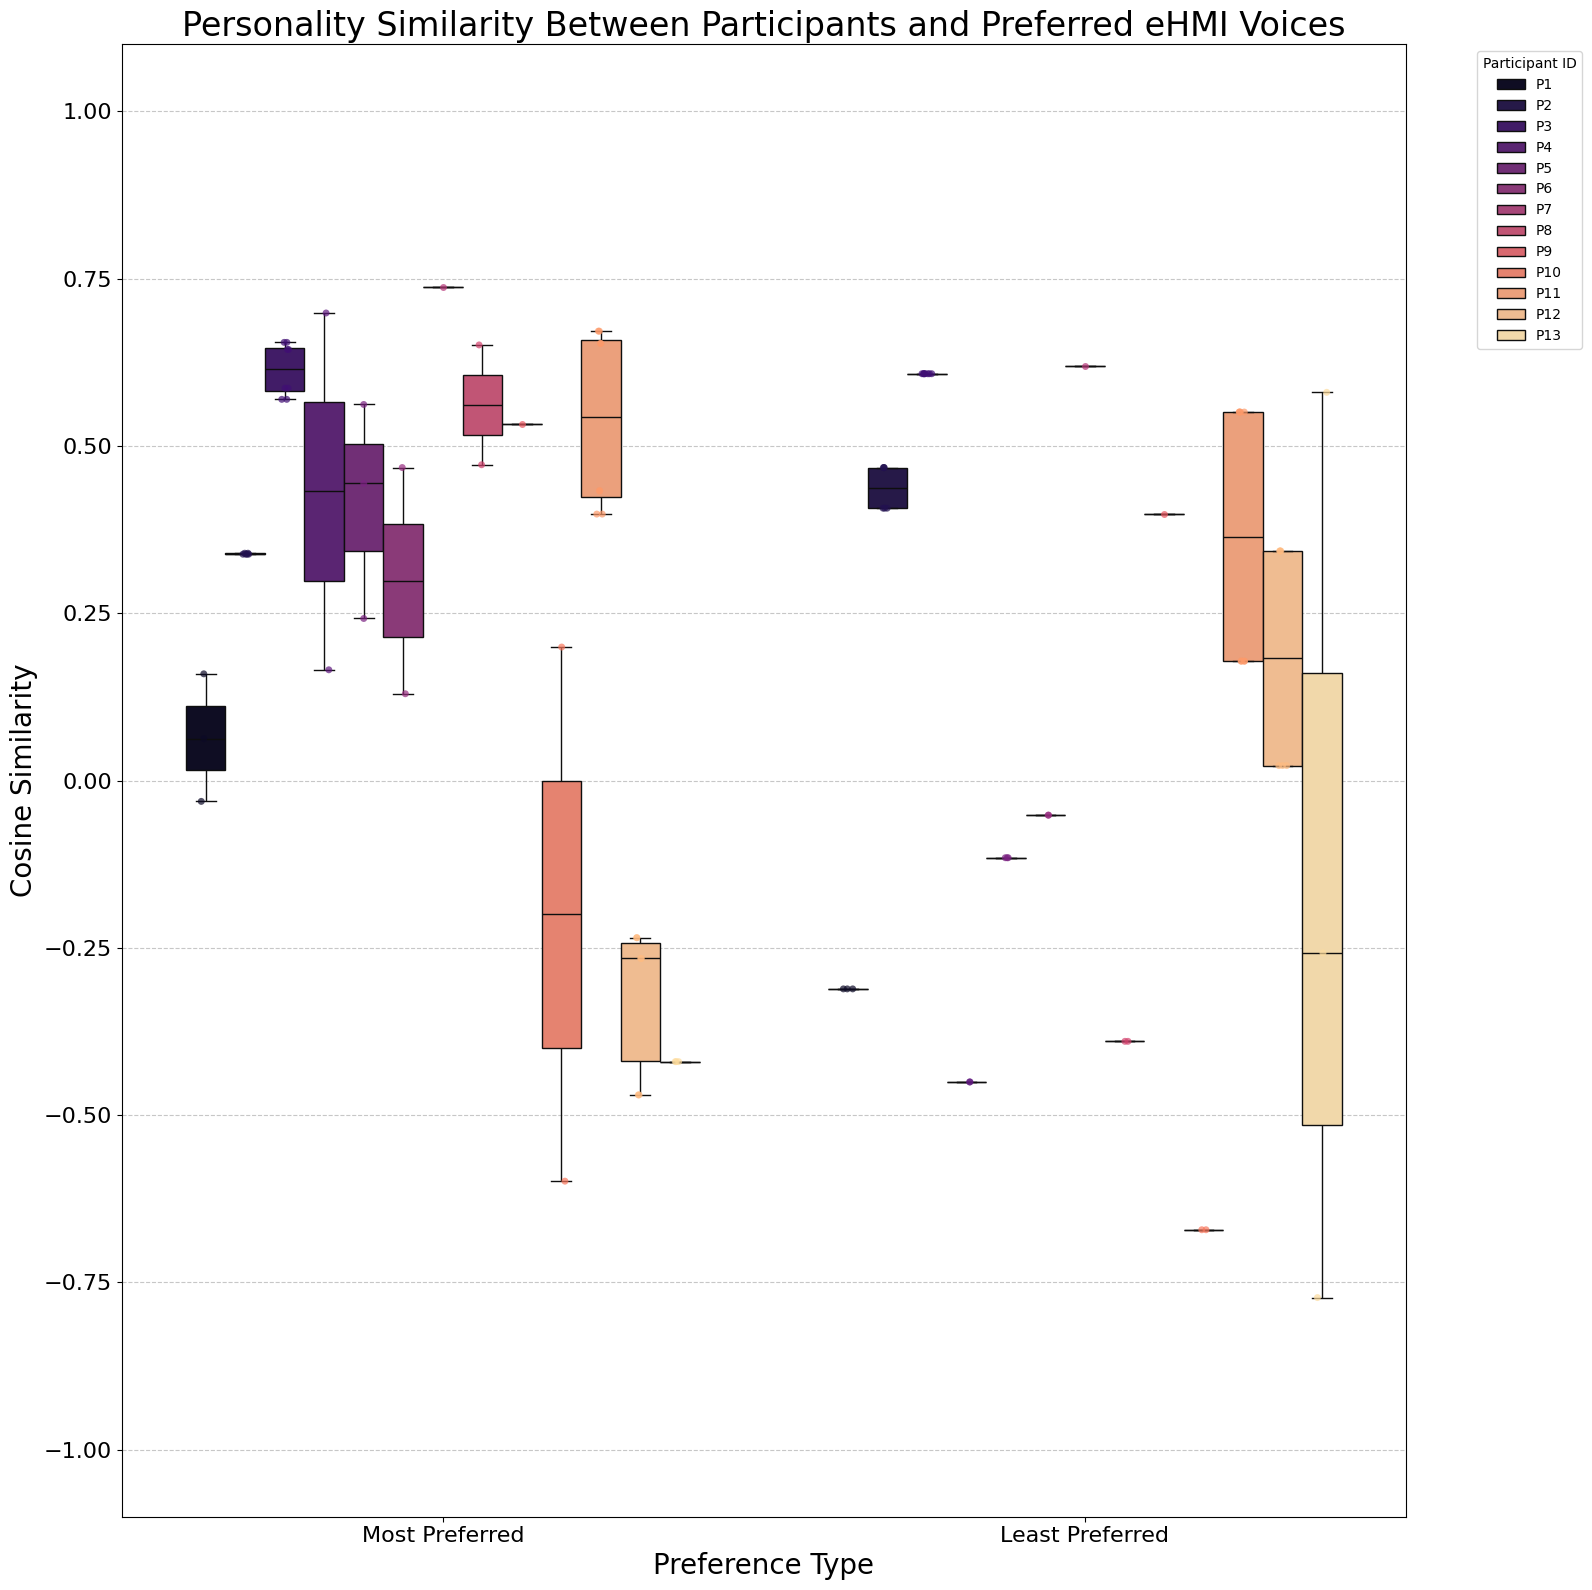


Statistics for Most Preferred Similarity:
count    47.000000
mean      0.275426
std       0.391186
min      -0.598619
25%       0.096182
50%       0.398119
75%       0.586220
max       0.737545
Name: Similarity, dtype: float64

Statistics for Least Preferred Similarity:
count    47.000000
mean      0.162959
std       0.418126
min      -0.772539
25%      -0.115368
50%       0.342981
75%       0.550590
max       0.618916
Name: Similarity, dtype: float64

Independent t-test: t=1.347, p=0.1814
Paired t-test: t=2.067, p=0.0610


In [11]:
# Create box plots of personality similarity for each participant
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('default')
# Check if we have 13 participants as expected
similarity_df = pd.read_excel("./output/processed_data/personality_similarity_bfi.xlsx")

unique_participants = similarity_df["Participant ID"].unique()
print(f"Number of unique participants: {len(unique_participants)}")

# Reshape the data for plotting
plot_data = []

for participant in unique_participants:
    participant_data = similarity_df[similarity_df["Participant ID"] == participant]
    
    # Add rows for most preferred similarity
    for sim_value in participant_data["Most Preferred Similarity"]:
        plot_data.append({
            "Participant ID": participant,
            "Preference Type": "Most Preferred",
            "Similarity": sim_value
        })
    
    # Add rows for least preferred similarity
    for sim_value in participant_data["Least Preferred Similarity"]:
        plot_data.append({
            "Participant ID": participant,
            "Preference Type": "Least Preferred",
            "Similarity": sim_value
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the boxplot
plt.figure(figsize=(16, 16))

# Create color palette with a different color for each participant
colors = sns.color_palette("magma", len(unique_participants))
participant_colors = {pid: color for pid, color in zip(unique_participants, colors)}

# Create the boxplot with participant-specific colors
ax = sns.boxplot(
    x="Preference Type",
    y="Similarity",
    hue="Participant ID",
    data=plot_df,
    palette=participant_colors,
    width=0.8
)

# Add stripplot to show individual data points
sns.stripplot(
    x="Preference Type",
    y="Similarity",
    hue="Participant ID",
    data=plot_df,
    dodge=True,
    alpha=0.7,
    palette=participant_colors,
    size=5
)

# Improve the plot appearance
plt.title("Personality Similarity Between Participants and Preferred eHMI Voices", fontsize=24)
plt.xlabel("Preference Type", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Cosine Similarity", fontsize=20)
plt.ylim(-1.1, 1.1)  # Cosine similarity ranges from -1 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust legend to prevent overcrowding
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles[:len(unique_participants)], 
    labels[:len(unique_participants)], 
    title="Participant ID", 
    bbox_to_anchor=(1.05, 1), 
    loc='upper left'
)

plt.tight_layout()
plt.savefig("./output/figures/participant_similarity_comparison.png", dpi=300)
plt.show()

# Also calculate and display statistics
print("\nStatistics for Most Preferred Similarity:")
print(plot_df[plot_df["Preference Type"] == "Most Preferred"]["Similarity"].describe())

print("\nStatistics for Least Preferred Similarity:")
print(plot_df[plot_df["Preference Type"] == "Least Preferred"]["Similarity"].describe())

# Paired t-test to check if the difference is significant
from scipy import stats
most_pref = plot_df[plot_df["Preference Type"] == "Most Preferred"]["Similarity"]
least_pref = plot_df[plot_df["Preference Type"] == "Least Preferred"]["Similarity"]

t_stat, p_val = stats.ttest_ind(most_pref, least_pref)
print(f"\nIndependent t-test: t={t_stat:.3f}, p={p_val:.4f}")

# Calculate the average similarity for each participant
participant_averages = plot_df.groupby(["Participant ID", "Preference Type"])["Similarity"].mean().reset_index()
wide_averages = participant_averages.pivot(
    index="Participant ID",
    columns="Preference Type",
    values="Similarity"
)

# Paired t-test (more appropriate since these are from the same participants)
paired_t_stat, paired_p_val = stats.ttest_rel(
    wide_averages["Most Preferred"], 
    wide_averages["Least Preferred"]
)
print(f"Paired t-test: t={paired_t_stat:.3f}, p={paired_p_val:.4f}")

c:\Users\phuongnam-d\anaconda3\envs\audio310\lib\site-packages\pingouin\plotting.py:573: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["wthn"] = data[within].replace({_ordr: i for i, _ordr in enumerate(order)})


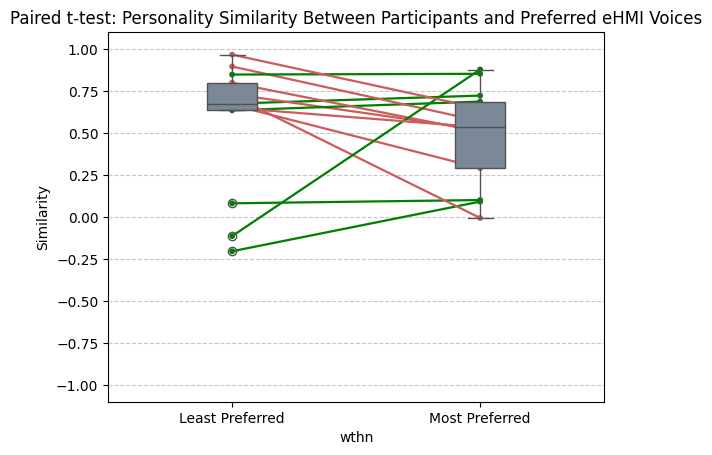

In [8]:
import pingouin as pg
plot_data_df = pd.DataFrame(plot_data)
ax = pg.plot_paired(data=plot_data_df, dv='Similarity', within='Preference Type', subject='Participant ID')
ax.set_title("Paired t-test: Personality Similarity Between Participants and Preferred eHMI Voices")
ax.set_ylim(-1.1, 1.1)  # Cosine similarity ranges from -1 to 1
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("./output/figures/paired_t_test_personality_similarity_label.png", dpi=300)
plt.show()

# Training model

In [13]:
# dataset
database_df = pd.read_csv('./output/processed_data/database_df.csv')
print(database_df.columns)
print(database_df.head())

Index(['Participant ID', 'Student ID', 'Name', 'Participant Gender',
       'Nationality', 'TIPI 1 O', 'TIPI 1 C', 'TIPI 1 E', 'TIPI 1 A',
       'TIPI 1 N', 'Condition', 'eHMI_ID', 'Type', 'eHMI Gender', 'EXT', 'AGR',
       'CON', 'NEU', 'OPN', 'Encounter', 'SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5',
       'BFI O', 'BFI C', 'BFI E', 'BFI A', 'BFI N', 'Overall', 'VQ1', 'VQ2',
       'VQ3', 'VQ4', 'VQ5', 'VQ6', 'VQ7', 'VQ8', 'VQ9', 'VQ10', 'VQ11', 'VQ12',
       'VQ13', 'VQ14', 'VQ15', 'VQ16'],
      dtype='object')
  Participant ID  Student ID    Name Participant Gender Nationality  TIPI 1 O  \
0             P1     2421414  Hanief               Male   Indonesia        12   
1             P1     2421414  Hanief               Male   Indonesia        12   
2             P1     2421414  Hanief               Male   Indonesia        12   
3             P1     2421414  Hanief               Male   Indonesia        12   
4             P1     2421414  Hanief               Male   Indonesia        12   


## 1. Simple FC model

In [20]:
# Create a neural network using PyTorch to predict Overall (as one-hot) and BFI from TIPI and Labels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
import os
from tqdm import tqdm

In [31]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directories
os.makedirs('./output/models', exist_ok=True)
os.makedirs('./output/figures/prediction', exist_ok=True)

print("Creating PyTorch neural network with one-hot encoded Overall score")

# 1. Prepare the data
# Define the column groups
tipi_cols = ["TIPI 1 O", "TIPI 1 C", "TIPI 1 E", "TIPI 1 A", "TIPI 1 N"]
bfi_cols = ["BFI O", "BFI C", "BFI E", "BFI A", "BFI N"]
label_cols = ["OPN", "CON", "EXT", "AGR", "NEU"]  # eHMI personality labels

# Create a clean copy of the data
nn_data = database_df.copy()

# Check for missing values
print("\nChecking missing values in data:")
print(nn_data[tipi_cols + ['Overall'] + bfi_cols + label_cols].isnull().sum())

# Drop rows with missing values in key columns
nn_data = nn_data.dropna(subset=tipi_cols + ['Overall'] + bfi_cols + label_cols)
print(f"Data shape after dropping missing values: {nn_data.shape}")

# 2. Preprocess the data
# Convert Overall to integers (if not already)
nn_data['Overall'] = nn_data['Overall'].round().astype(int)

# Check Overall distribution
overall_dist = nn_data['Overall'].value_counts().sort_index()
print("\nDistribution of Overall scores:")
print(overall_dist)

# One-hot encode the Overall scores (1-5)
encoder_overall = OneHotEncoder(sparse_output=False, categories=[[1, 2, 3, 4, 5]])
overall_onehot = encoder_overall.fit_transform(nn_data[['Overall']])

# Create column names for the one-hot encoded Overall
overall_onehot_cols = [f'Overall_{i}' for i in range(1, 6)]

# Combine TIPI with labels to create input features
X_input = nn_data[tipi_cols + label_cols].copy()
y_bfi = nn_data[bfi_cols].copy()
y_overall_onehot = pd.DataFrame(overall_onehot, columns=overall_onehot_cols)

# Scale the numerical inputs and BFI outputs (don't scale one-hot vectors)
scaler_X = StandardScaler()
scaler_y_bfi = StandardScaler()

# Get column names for later use
X_cols = X_input.columns

# Scale the data
X_scaled = scaler_X.fit_transform(X_input)
y_bfi_scaled = scaler_y_bfi.fit_transform(y_bfi)

# Split the data into training and testing sets
X_train, X_test, y_bfi_train, y_bfi_test, y_overall_train, y_overall_test = train_test_split(
    X_scaled, y_bfi_scaled, overall_onehot, test_size=0.2, random_state=42
)

print(f"Training data shape: X={X_train.shape}, y_bfi={y_bfi_train.shape}, y_overall={y_overall_train.shape}")
print(f"Testing data shape: X={X_test.shape}, y_bfi={y_bfi_test.shape}, y_overall={y_overall_test.shape}")

Creating PyTorch neural network with one-hot encoded Overall score

Checking missing values in data:
TIPI 1 O    0
TIPI 1 C    0
TIPI 1 E    0
TIPI 1 A    0
TIPI 1 N    0
Overall     0
BFI O       0
BFI C       0
BFI E       0
BFI A       0
BFI N       0
OPN         0
CON         0
EXT         0
AGR         0
NEU         0
dtype: int64
Data shape after dropping missing values: (156, 47)

Distribution of Overall scores:
Overall
1     8
2    22
3    34
4    48
5    44
Name: count, dtype: int64
Training data shape: X=(124, 10), y_bfi=(124, 5), y_overall=(124, 5)
Testing data shape: X=(32, 10), y_bfi=(32, 5), y_overall=(32, 5)


In [46]:
# 3. Create PyTorch datasets and dataloaders
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_bfi_train_tensor = torch.FloatTensor(y_bfi_train)
y_overall_train_tensor = torch.FloatTensor(y_overall_train)

X_test_tensor = torch.FloatTensor(X_test)
y_bfi_test_tensor = torch.FloatTensor(y_bfi_test)
y_overall_test_tensor = torch.FloatTensor(y_overall_test)

# Create TensorDatasets with combined targets
train_dataset = TensorDataset(X_train_tensor, y_bfi_train_tensor, y_overall_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_bfi_test_tensor, y_overall_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
from torchvision import models
from torchinfo import summary

# 4. Define the neural network model with two output heads
class PersonalityPreferenceNet(nn.Module):
    def __init__(self, input_dim, bfi_dim=5, overall_dim=5):
        super(PersonalityPreferenceNet, self).__init__()
        
        # Shared layers
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # BFI prediction branch (regression)
        self.bfi_branch = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, bfi_dim)  # Linear output for regression
        )
        
        # Overall score prediction branch (classification)
        self.overall_branch = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, overall_dim)  # Logits for 5 classes
        )
    
    def forward(self, x):
        # Shared feature extraction
        shared_features = self.shared_layers(x)
        
        # Predict BFI traits (regression)
        bfi_pred = self.bfi_branch(shared_features)
        
        # Predict Overall score (classification logits)
        overall_pred = self.overall_branch(shared_features)
        
        return bfi_pred, overall_pred

# Instantiate the model
input_dim = X_train.shape[1]
model = PersonalityPreferenceNet(input_dim)

# Print model architecture
print("\nModel architecture:")
print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
summary(model, input_size=(batch_size, input_dim))


Model architecture:
PersonalityPreferenceNet(
  (shared_layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (bfi_branch): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=5, bias=True)
  )
  (overall_branch): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=5, bias=True

Layer (type:depth-idx)                   Output Shape              Param #
PersonalityPreferenceNet                 [32, 5]                   --
├─Sequential: 1-1                        [32, 32]                  --
│    └─Linear: 2-1                       [32, 64]                  704
│    └─BatchNorm1d: 2-2                  [32, 64]                  128
│    └─ReLU: 2-3                         [32, 64]                  --
│    └─Dropout: 2-4                      [32, 64]                  --
│    └─Linear: 2-5                       [32, 32]                  2,080
│    └─BatchNorm1d: 2-6                  [32, 32]                  64
│    └─ReLU: 2-7                         [32, 32]                  --
│    └─Dropout: 2-8                      [32, 32]                  --
├─Sequential: 1-2                        [32, 5]                   --
│    └─Linear: 2-9                       [32, 16]                  528
│    └─BatchNorm1d: 2-10                 [32, 16]                  32
│    └─Re


(process:23620): Pango-WARNING **: 12:44:29.556: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


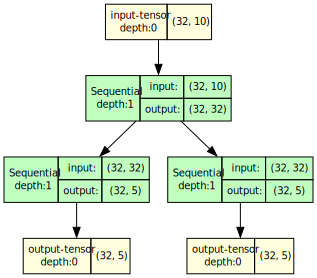

In [51]:
from torchview import draw_graph
graph = draw_graph(model, input_size=(batch_size, input_dim), depth=1, show_shapes=True)
graph.visual_graph

In [57]:
# 5. Training setup
# Define loss functions for each task
bfi_criterion = nn.MSELoss()  # MSE for BFI regression
overall_criterion = nn.CrossEntropyLoss()  # Cross entropy for Overall classification

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# 6. Train the model
num_epochs = 500
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience = 20  # Early stopping patience
counter = 0

print("\nTraining the model...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_bfi_loss = 0.0
    running_overall_loss = 0.0
    
    for inputs, bfi_targets, overall_targets in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        bfi_outputs, overall_outputs = model(inputs)
        
        # Calculate losses for each task
        bfi_loss = bfi_criterion(bfi_outputs, bfi_targets)
        overall_loss = overall_criterion(overall_outputs, torch.max(overall_targets, 1)[1])  # Convert one-hot to class indices
        
        # Combined loss - weighting both tasks
        loss = bfi_loss + overall_loss
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track losses
        running_loss += loss.item() * inputs.size(0)
        running_bfi_loss += bfi_loss.item() * inputs.size(0)
        running_overall_loss += overall_loss.item() * inputs.size(0)
    
    # Calculate epoch losses
    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_bfi_loss = running_bfi_loss / len(train_loader.dataset)
    epoch_overall_loss = running_overall_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_val_bfi_loss = 0.0
    running_val_overall_loss = 0.0
    
    with torch.no_grad():
        for inputs, bfi_targets, overall_targets in test_loader:
            bfi_outputs, overall_outputs = model(inputs)
            
            # Calculate validation losses
            bfi_loss = bfi_criterion(bfi_outputs, bfi_targets)
            overall_loss = overall_criterion(overall_outputs, torch.max(overall_targets, 1)[1])
            loss = bfi_loss + overall_loss
            
            running_val_loss += loss.item() * inputs.size(0)
            running_val_bfi_loss += bfi_loss.item() * inputs.size(0)
            running_val_overall_loss += overall_loss.item() * inputs.size(0)
    
    # Calculate epoch validation losses
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    epoch_val_bfi_loss = running_val_bfi_loss / len(test_loader.dataset)
    epoch_val_overall_loss = running_val_overall_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    # Update learning rate
    scheduler.step(epoch_val_loss)
    
    # Print progress
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_train_loss:.4f}/{epoch_val_loss:.4f}, '
              f'BFI: {epoch_bfi_loss:.4f}/{epoch_val_bfi_loss:.4f}, '
              f'Overall: {epoch_overall_loss:.4f}/{epoch_val_overall_loss:.4f}')
    
    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break


Training the model...
Epoch 1/500, Loss: 2.8515/2.6517, BFI: 1.1134/1.0631, Overall: 1.7380/1.5886
Epoch 10/500, Loss: 2.4444/2.5095, BFI: 0.9145/0.9692, Overall: 1.5299/1.5403
Epoch 20/500, Loss: 2.2822/2.2949, BFI: 0.8527/0.8630, Overall: 1.4295/1.4319
Epoch 30/500, Loss: 2.0309/2.1286, BFI: 0.7598/0.7724, Overall: 1.2712/1.3562
Epoch 40/500, Loss: 1.9335/2.0225, BFI: 0.7183/0.7153, Overall: 1.2151/1.3072
Epoch 50/500, Loss: 1.8273/1.9234, BFI: 0.6754/0.6526, Overall: 1.1518/1.2709
Epoch 60/500, Loss: 1.7248/1.8372, BFI: 0.6686/0.6054, Overall: 1.0561/1.2318
Epoch 70/500, Loss: 1.5529/1.7651, BFI: 0.5947/0.5677, Overall: 0.9581/1.1974
Epoch 80/500, Loss: 1.5507/1.7021, BFI: 0.6052/0.5392, Overall: 0.9456/1.1628
Epoch 90/500, Loss: 1.4673/1.6715, BFI: 0.5570/0.5301, Overall: 0.9103/1.1414
Epoch 100/500, Loss: 1.4077/1.6216, BFI: 0.5526/0.5080, Overall: 0.8552/1.1135
Epoch 110/500, Loss: 1.3134/1.6018, BFI: 0.5509/0.5080, Overall: 0.7625/1.0938
Epoch 120/500, Loss: 1.3498/1.5793, BFI:

In [58]:
# Load the best model
if 'best_model_state' in locals():
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation loss: {best_val_loss:.6f}")

# 7. Evaluate the model
model.eval()
y_bfi_preds = []
y_overall_preds = []
y_bfi_true = []
y_overall_true = []

with torch.no_grad():
    for inputs, bfi_targets, overall_targets in test_loader:
        bfi_outputs, overall_outputs = model(inputs)
        
        # Apply softmax to overall outputs to get probabilities
        overall_probs = torch.softmax(overall_outputs, dim=1)
        
        # Store predictions and targets
        y_bfi_preds.append(bfi_outputs.numpy())
        y_overall_preds.append(overall_probs.numpy())
        y_bfi_true.append(bfi_targets.numpy())
        y_overall_true.append(overall_targets.numpy())

# Concatenate batches
y_bfi_pred_scaled = np.vstack(y_bfi_preds)
y_overall_pred_probs = np.vstack(y_overall_preds)
y_bfi_test_stacked = np.vstack(y_bfi_true)
y_overall_test_stacked = np.vstack(y_overall_true)

# Get class predictions from probabilities
y_overall_pred_class = np.argmax(y_overall_pred_probs, axis=1) + 1  # Add 1 to get back to 1-5 scale
y_overall_true_class = np.argmax(y_overall_test_stacked, axis=1) + 1

# Inverse transform BFI predictions to original scale
y_bfi_pred = scaler_y_bfi.inverse_transform(y_bfi_pred_scaled)
y_bfi_test_unscaled = scaler_y_bfi.inverse_transform(y_bfi_test_stacked)

# Calculate BFI evaluation metrics
bfi_mse = []
bfi_r2 = []
for i, col in enumerate(bfi_cols):
    bfi_mse.append(mean_squared_error(y_bfi_test_unscaled[:, i], y_bfi_pred[:, i]))
    bfi_r2.append(r2_score(y_bfi_test_unscaled[:, i], y_bfi_pred[:, i]))

# Create BFI evaluation table
bfi_eval_df = pd.DataFrame({
    'Output': bfi_cols,
    'MSE': bfi_mse,
    'RMSE': np.sqrt(bfi_mse),
    'R2': bfi_r2
})

# Calculate Overall classification metrics
overall_accuracy = accuracy_score(y_overall_true_class, y_overall_pred_class)
overall_cm = confusion_matrix(y_overall_true_class, y_overall_pred_class, normalize='true')

print("\nBFI Regression Evaluation:")
print(bfi_eval_df)

print("\nOverall Classification Evaluation:")
print(f"Accuracy: {overall_accuracy:.4f}")
print("Confusion Matrix:")
print(overall_cm)

Loaded best model with validation loss: 1.537319

BFI Regression Evaluation:
  Output       MSE      RMSE        R2
0  BFI O  1.627174  1.275607  0.390776
1  BFI C  1.893434  1.376021  0.448556
2  BFI E  1.967095  1.402531  0.531884
3  BFI A  1.582664  1.258040  0.543222
4  BFI N  0.917381  0.957800  0.674611

Overall Classification Evaluation:
Accuracy: 0.5938
Confusion Matrix:
[[0.         0.         1.         0.         0.        ]
 [0.         0.5        0.         0.16666667 0.33333333]
 [0.         0.11111111 0.44444444 0.44444444 0.        ]
 [0.         0.         0.         0.77777778 0.22222222]
 [0.         0.         0.         0.28571429 0.71428571]]


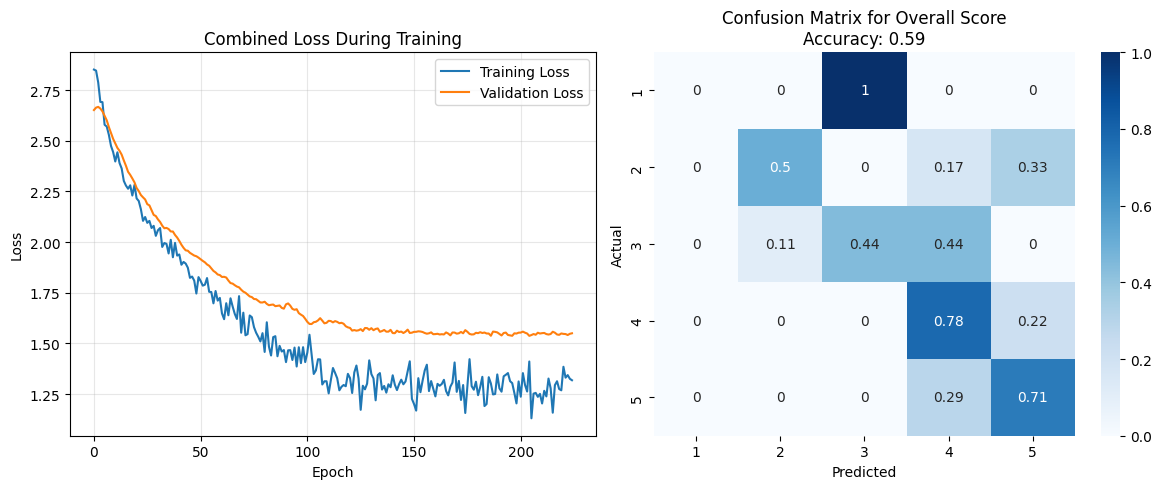

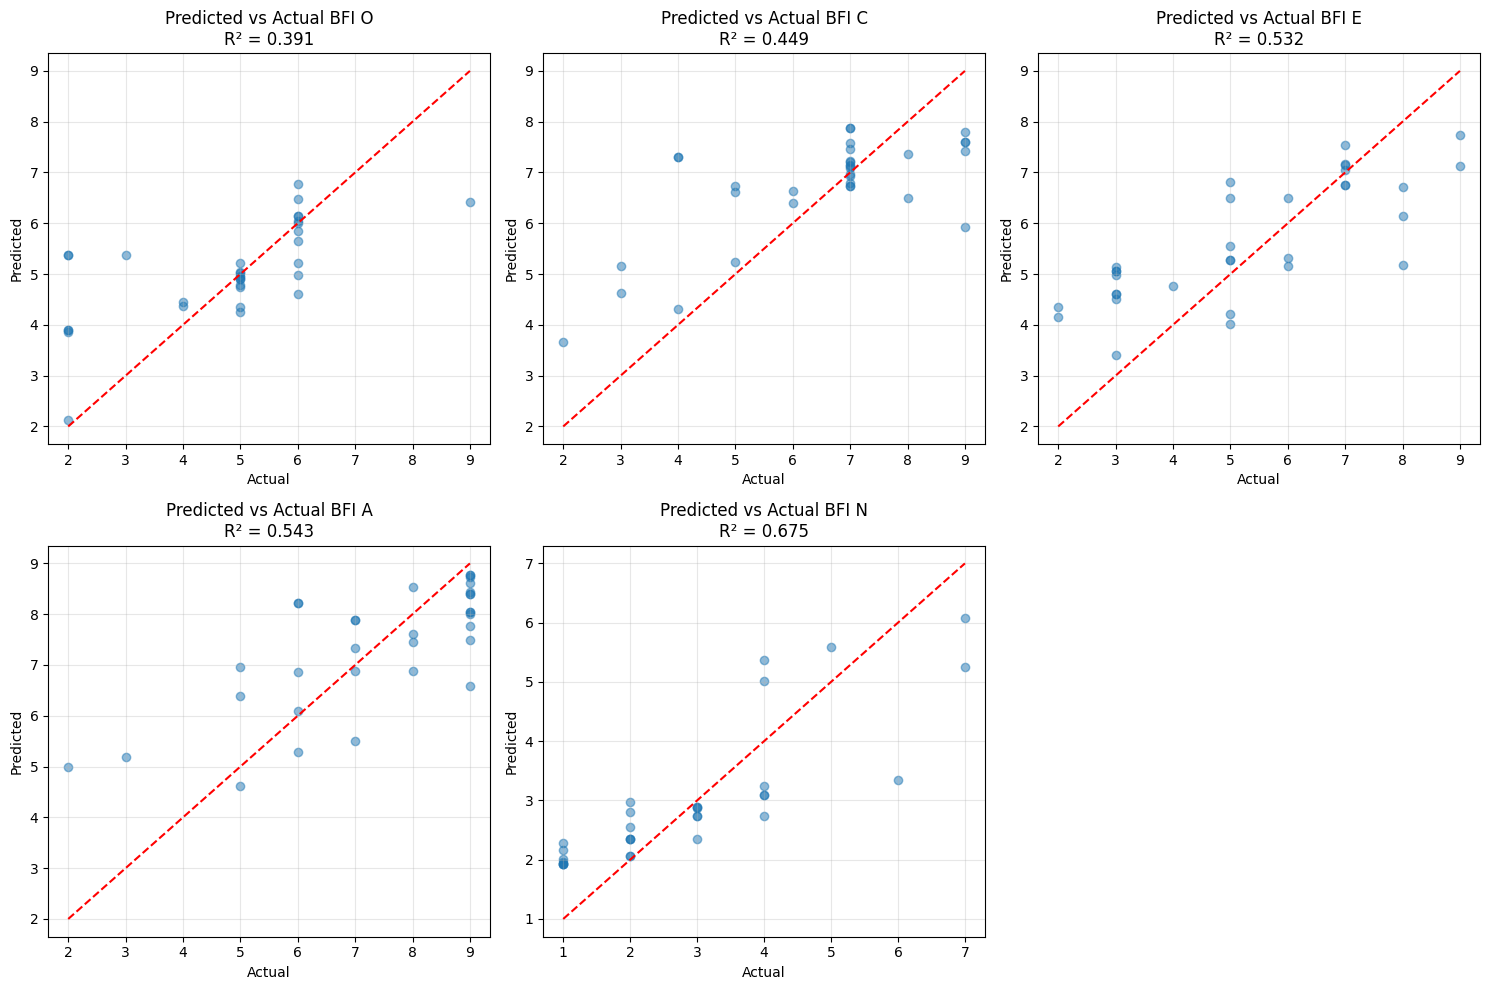

In [59]:
# 8. Create visualizations
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Combined Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Confusion matrix heatmap for Overall classification
sns.heatmap(overall_cm, annot=True,  cmap='Blues', 
            xticklabels=range(1, 6), yticklabels=range(1, 6))
plt.title(f'Confusion Matrix for Overall Score\nAccuracy: {overall_accuracy:.2f}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.savefig('./output/figures/prediction/training_results_onehot.png', dpi=300)
plt.show()

# Create a figure for BFI regression results
plt.figure(figsize=(15, 10))
for i, col in enumerate(bfi_cols):
    plt.subplot(2, 3, i+1)
    plt.scatter(y_bfi_test_unscaled[:, i], y_bfi_pred[:, i], alpha=0.5)
    plt.plot([min(y_bfi_test_unscaled[:, i]), max(y_bfi_test_unscaled[:, i])], 
             [min(y_bfi_test_unscaled[:, i]), max(y_bfi_test_unscaled[:, i])], 
             'r--')
    plt.title(f'Predicted vs Actual {col}\nR² = {bfi_r2[i]:.3f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./output/figures/prediction/bfi_prediction_results.png', dpi=300)
plt.show()

# # 9. Feature Importance Analysis
# def calculate_feature_importance(model, X, y_bfi, y_overall, feature_names):
#     # Calculate baseline performance
#     X_tensor = torch.FloatTensor(X)
#     y_bfi_tensor = torch.FloatTensor(y_bfi)
#     y_overall_tensor = torch.FloatTensor(y_overall)
    
#     model.eval()
#     with torch.no_grad():
#         bfi_pred, overall_pred = model(X_tensor)
#         bfi_loss = bfi_criterion(bfi_pred, y_bfi_tensor)
#         overall_loss = overall_criterion(overall_pred, torch.max(y_overall_tensor, 1)[1])
#         baseline_loss = bfi_loss + overall_loss
    
#     # Calculate importance for each feature
#     importance = []
#     for i in range(X.shape[1]):
#         # Create a copy of X with the i-th feature permuted
#         X_permuted = X.copy()
#         X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
#         X_permuted_tensor = torch.FloatTensor(X_permuted)
        
#         # Calculate new loss
#         with torch.no_grad():
#             bfi_pred, overall_pred = model(X_permuted_tensor)
#             bfi_loss = bfi_criterion(bfi_pred, y_bfi_tensor)
#             overall_loss = overall_criterion(overall_pred, torch.max(y_overall_tensor, 1)[1])
#             new_loss = bfi_loss + overall_loss
        
#         # Feature importance = increase in loss when feature is permuted
#         feature_imp = new_loss.item() - baseline_loss.item()
#         importance.append(feature_imp)
    
#     # Create a DataFrame
#     importance_df = pd.DataFrame({
#         'Feature': feature_names,
#         'Importance': importance
#     })
    
#     return importance_df.sort_values('Importance', ascending=False)

# print("\nCalculating feature importance...")
# feature_importance = calculate_feature_importance(
#     model, X_test, y_bfi_test_tensor, y_overall_test_tensor, X_cols
# )

# print("\nFeature Importance:")
# print(feature_importance)

# # Plot feature importance
# plt.figure(figsize=(12, 8))
# plt.barh(feature_importance['Feature'], feature_importance['Importance'])
# plt.title('Feature Importance (Permutation Method)', fontsize=14)
# plt.xlabel('Increase in Loss when Feature is Permuted', fontsize=12)
# plt.ylabel('Feature', fontsize=12)
# plt.gca().invert_yaxis()  # Show most important features at the top
# plt.grid(axis='x', alpha=0.3)
# plt.tight_layout()
# plt.savefig('./output/figures/prediction/feature_importance_onehot.png', dpi=300)
# plt.show()

# # 10. Make example predictions
# # Define example personalities
# example_personalities = [
#     {"name": "High Openness", "tipi": [12, 7, 7, 7, 7]},
#     {"name": "High Conscientiousness", "tipi": [7, 12, 7, 7, 7]},
#     {"name": "High Extraversion", "tipi": [7, 7, 12, 7, 7]},
#     {"name": "High Agreeableness", "tipi": [7, 7, 7, 12, 7]},
#     {"name": "High Neuroticism", "tipi": [7, 7, 7, 7, 12]},
#     {"name": "Average Person", "tipi": [7, 7, 7, 7, 7]},
# ]

# # Define example eHMI personality labels
# example_labels = [
#     {"name": "High Openness", "labels": [0.8, 0.5, 0.5, 0.5, 0.5]},
#     {"name": "High Conscientiousness", "labels": [0.5, 0.8, 0.5, 0.5, 0.5]},
#     {"name": "High Extraversion", "labels": [0.5, 0.5, 0.8, 0.5, 0.5]},
#     {"name": "High Agreeableness", "labels": [0.5, 0.5, 0.5, 0.8, 0.5]},
#     {"name": "High Neuroticism", "labels": [0.5, 0.5, 0.5, 0.5, 0.8]},
#     {"name": "Balanced", "labels": [0.5, 0.5, 0.5, 0.5, 0.5]},
# ]

# # Function for making predictions
# def predict_preference(tipi_values, label_values):
#     # Combine inputs
#     input_data = np.concatenate([tipi_values, label_values])
#     input_data = input_data.reshape(1, -1)
    
#     # Scale input
#     input_scaled = scaler_X.transform(input_data)
    
#     # Convert to tensor
#     input_tensor = torch.FloatTensor(input_scaled)
    
#     # Get prediction
#     model.eval()
#     with torch.no_grad():
#         bfi_pred, overall_pred = model(input_tensor)
#         overall_probs = torch.softmax(overall_pred, dim=1).numpy()[0]
#         bfi_pred_np = bfi_pred.numpy()
#         bfi_pred_unscaled = scaler_y_bfi.inverse_transform(bfi_pred_np)[0]
    
#     # Get most likely class
#     predicted_class = np.argmax(overall_probs) + 1
    
#     result = {
#         'Overall_Class': predicted_class,
#         'Overall_Confidence': overall_probs[predicted_class-1]
#     }
    
#     # Add class probabilities
#     for i in range(5):
#         result[f'Overall_{i+1}_Prob'] = overall_probs[i]
    
#     # Add BFI predictions
#     for i, col in enumerate(bfi_cols):
#         result[col] = bfi_pred_unscaled[i]
    
#     return result

# # Generate predictions for all combinations
# prediction_results = []

# for p_persona in example_personalities:
#     for e_persona in example_labels:
#         # Make prediction
#         pred = predict_preference(p_persona["tipi"], e_persona["labels"])
        
#         # Add to results
#         result = {
#             "Participant Type": p_persona["name"],
#             "eHMI Type": e_persona["name"],
#             "Predicted Overall": pred['Overall_Class'],
#             "Confidence": pred['Overall_Confidence']
#         }
        
#         # Add class probabilities
#         for i in range(1, 6):
#             result[f'Prob_{i}'] = pred[f'Overall_{i}_Prob']
        
#         # Add TIPI values
#         for i, trait in enumerate(tipi_cols):
#             short_name = trait.split(" ")[-1]
#             result[f"TIPI {short_name}"] = p_persona["tipi"][i]
        
#         # Add label values
#         for i, trait in enumerate(label_cols):
#             result[f"Label {trait}"] = e_persona["labels"][i]
            
#         # Add BFI predictions
#         for i, trait in enumerate(bfi_cols):
#             result[f"Predicted {trait}"] = pred[trait]
            
#         prediction_results.append(result)

# # Convert to DataFrame
# pred_df = pd.DataFrame(prediction_results)